## Airlines_Forecasting

In [248]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sn 
import plotly
from chart_studio import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as tsa_plots
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import warnings
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
import warnings
warnings.filterwarnings('ignore')

In [127]:
df = pd.read_excel(r"C:\Users\Adith\Desktop\Data Science_Excel R\home assignments\Forecasting and time series\Airlines+data.xlsx")

In [128]:

print('shape of data',df.shape)
df.head()

shape of data (96, 2)


Month  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121

## Data Exploration

In [129]:
#checking information od our data 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [130]:
#checking for any null values 
df.isna().sum()

Month         0
Passengers    0
dtype: int64

In [131]:
#checking for any duplicate values 
(df[df.duplicated()])

Empty DataFrame
Columns: [Month, Passengers]
Index: []

<AxesSubplot:>

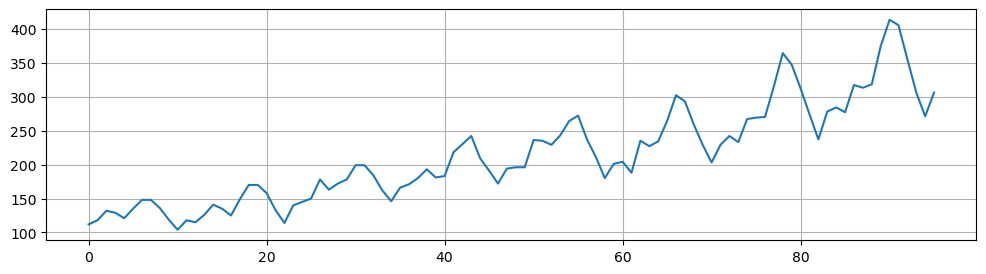

In [132]:
#checking the time series with the passengers 
df.Passengers.plot(grid='line',figsize =(12,3))

Its very clear that we having upward trend and as magnitude are not same its a multiplicative seasonality pattern also we observe that there is variation of mean and variance which indicates that our data is non-stationary

In [133]:
#checking with descriptive statistics 
df.describe()

Passengers
count   96.000000
mean   213.708333
std     71.918216
min    104.000000
25%    156.000000
50%    200.000000
75%    264.750000
max    413.000000

In [134]:
#checking with unique values 
df.nunique()

Month         96
Passengers    80
dtype: int64

## Feature extraction

In [135]:
#renaming our month column to date
df.rename({'Month':'Date'},axis=1,inplace=True)


In [136]:
df.head()

Date  Passengers
0 1995-01-01         112
1 1995-02-01         118
2 1995-03-01         132
3 1995-04-01         129
4 1995-05-01         121

In [137]:
#extracting our month and year column from date
df['Date'] = pd.to_datetime(df.Date,format="%b-%y")
df['Month']= df.Date.dt.strftime("%b")
df['Year'] = df['Date'].dt.year

In [138]:
df.head()

Date  Passengers Month  Year
0 1995-01-01         112   Jan  1995
1 1995-02-01         118   Feb  1995
2 1995-03-01         132   Mar  1995
3 1995-04-01         129   Apr  1995
4 1995-05-01         121   May  1995

In [139]:
df1 = df[['Date','Passengers']]
df1.set_index('Date',inplace = True)


## Data Visualization

<AxesSubplot:xlabel='Month', ylabel='Year'>

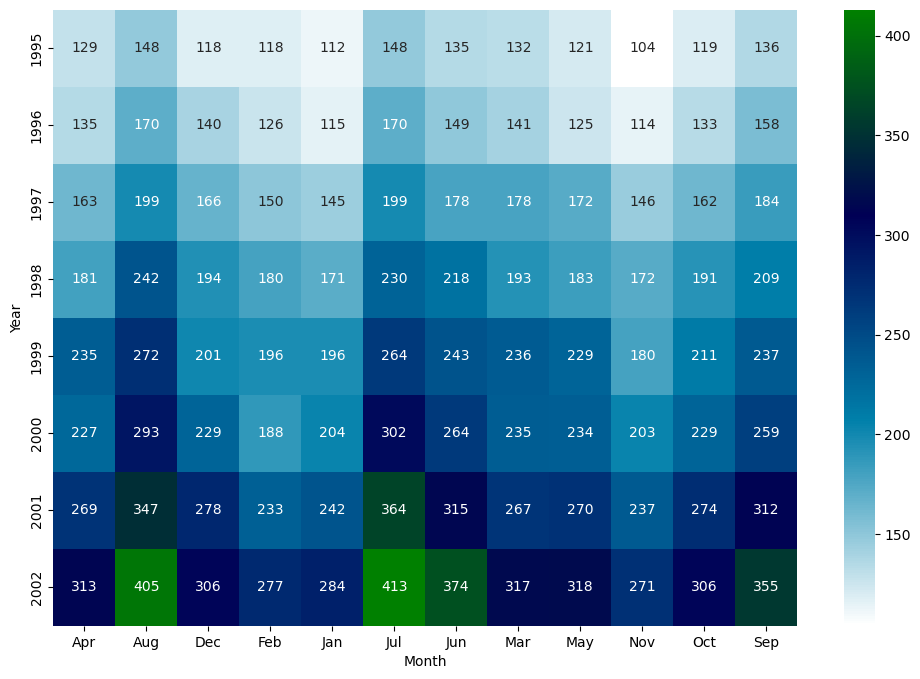

In [140]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=df,values="Passengers",index="Year",columns="Month",aggfunc='mean',fill_value=0)
sn.heatmap(heatmap_y_month,annot=True,fmt="g",cmap='ocean_r')

According to Heatmap we can observe that compared from year 1995, in the year 2002 the rise in airlines passengers especially month of august and july, this also indicates that use of flghts might rise in future due to leading rate of population 

<AxesSubplot:xlabel='Year', ylabel='Passengers'>

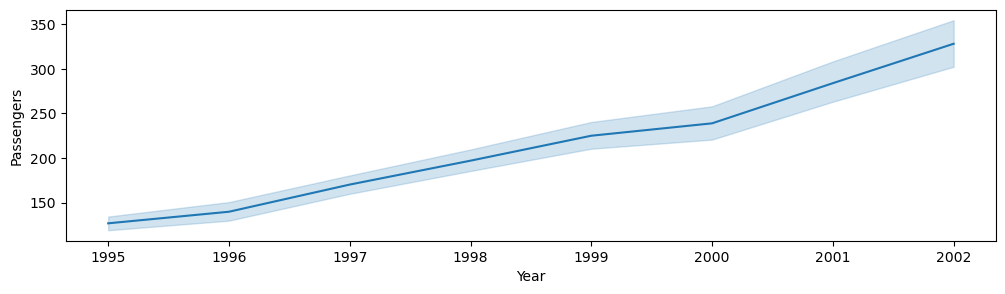

In [141]:
#Yearly Analysis of the passengers 
plt.figure(figsize=(12,3))
sn.lineplot(x = "Year",y = "Passengers",data=df,markers='o')

As we have seen above heatmap we observe the same in lineplot that rise in passengers and usage of flights 

<AxesSubplot:xlabel='Year', ylabel='Passengers'>

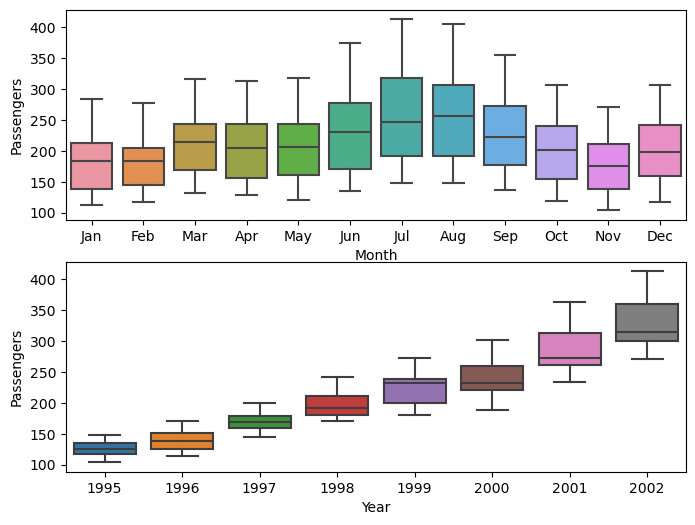

In [142]:
# Boxplot for ever
plt.figure(figsize=(8,6))
plt.subplot(211)
sn.boxplot(x="Month",y="Passengers",data=df)
plt.subplot(212)
sn.boxplot(x="Year",y="Passengers",data=df)


<AxesSubplot:ylabel='Density'>

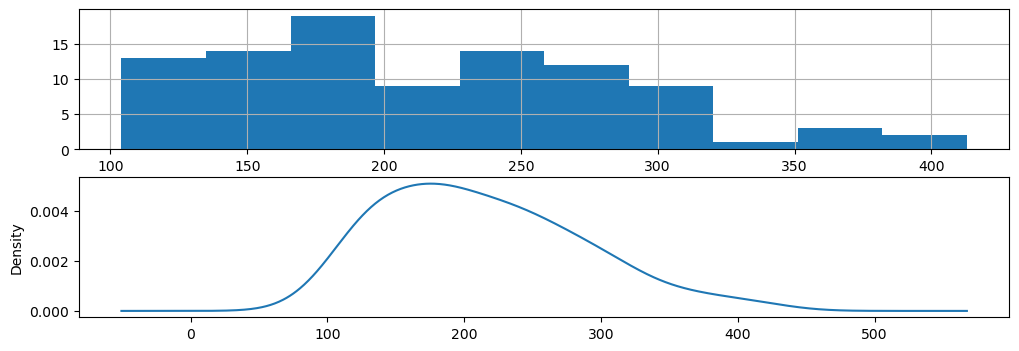

In [143]:
#passenger histplot and density plot 
plt.figure(figsize=(12,4))
plt.subplot(211)
df.Passengers.hist()
plt.subplot(212)
df.Passengers.plot(kind = 'kde')



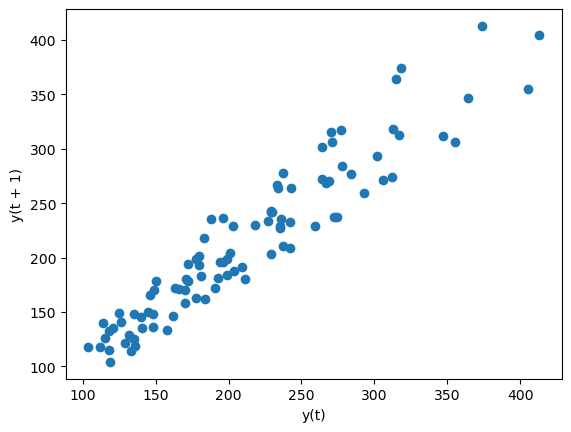

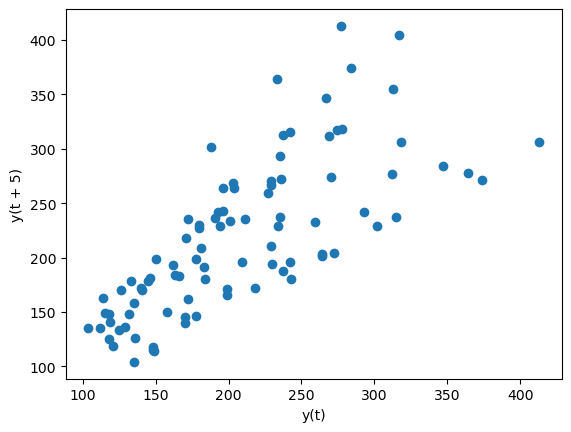

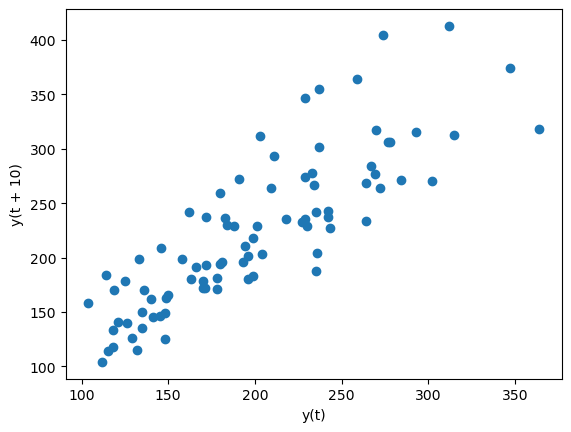

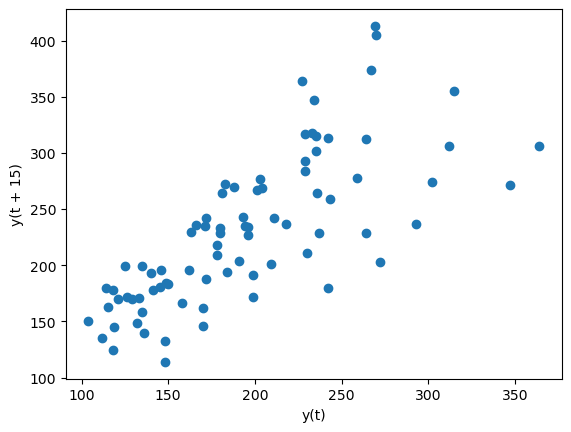

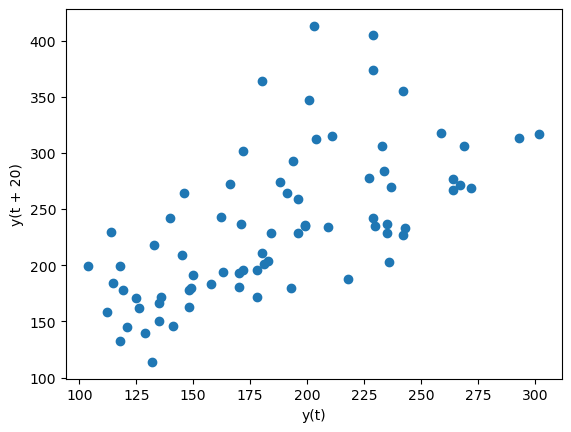

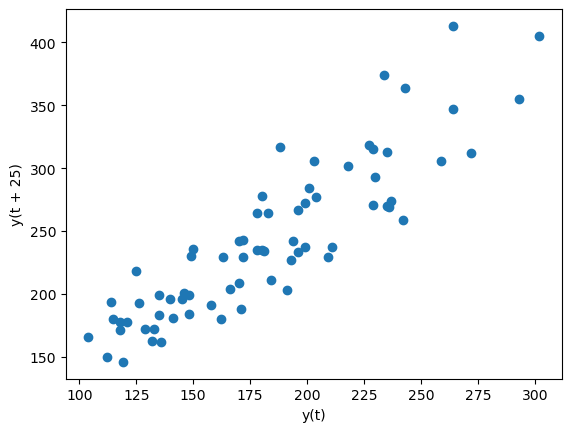

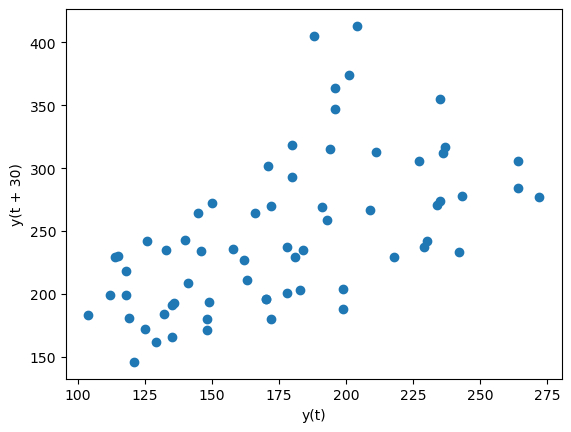

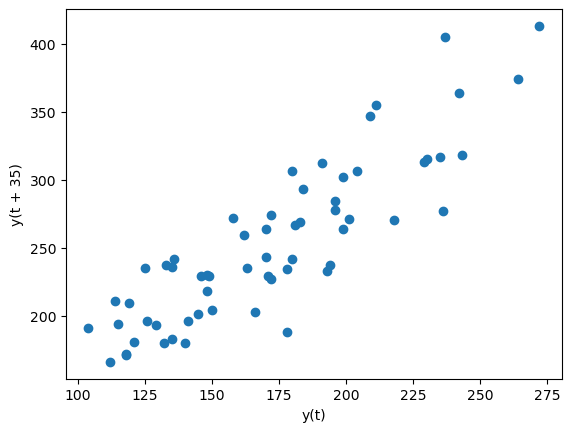

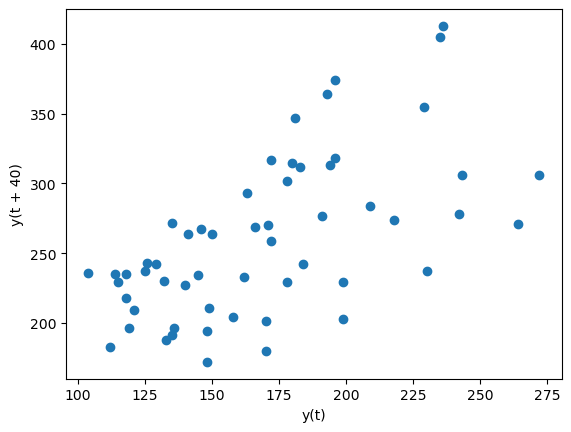

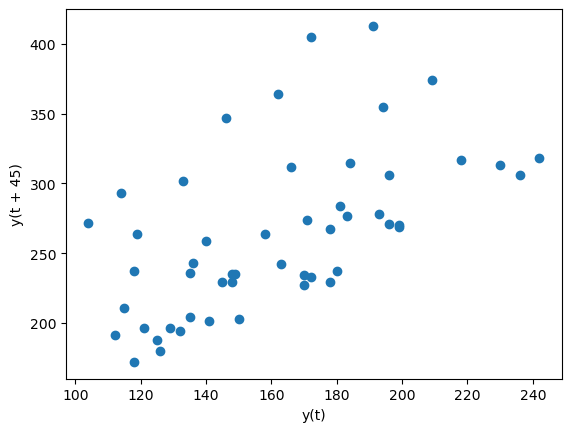

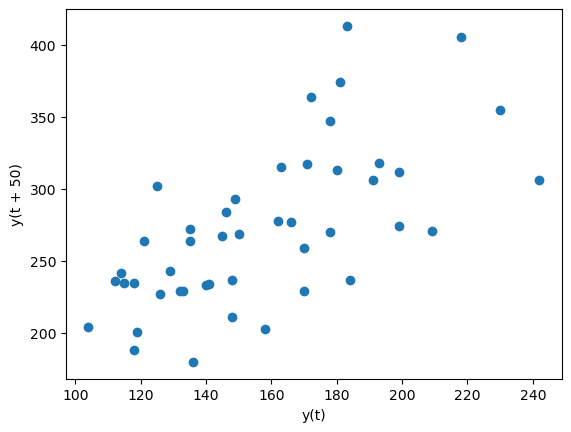

In [144]:
#Lag plot for passengers
for i in [1,5,10,15,20,25,30,35,40,45,50]:
    pd.plotting.lag_plot(df.Passengers,lag = i)
    plt.show()

In [145]:
#moving average  using plotly
x = pd.date_range('1995-01-01', periods=30, freq='D')
y = df.Passengers

window_sizes = [5,10,15,20]
trend_length = 10

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=x, y=y, name='Original Data')
)

for window_size in window_sizes:
    rolling_mean = y.rolling(window_size).mean()
    fig.add_trace(
        go.Scatter(x=x, y=rolling_mean, name=f'Simple Moving Average ({window_size} days)')
    )

# Update figure layout
fig.update_layout(title='Moving Average Passenger', xaxis_title='Date', yaxis_title='Value',height = 350)

# Show figure
fig.show()


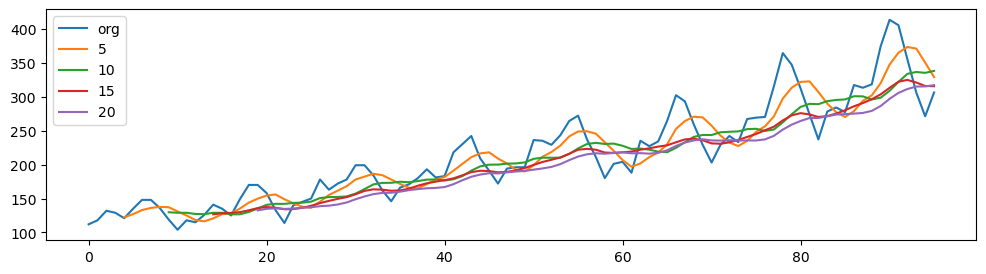

In [146]:
#plotting moving average with trends 
plt.figure(figsize=(12,3))
df.Passengers.plot(label="org")
for i in range(5,25,5):
    df["Passengers"].rolling(i).mean().plot(label=str(i))
plt.legend(loc='best')

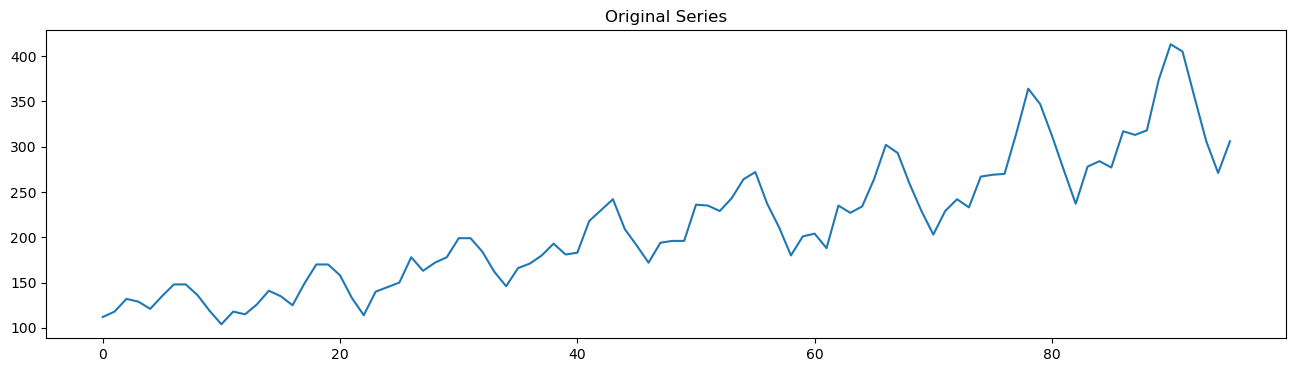

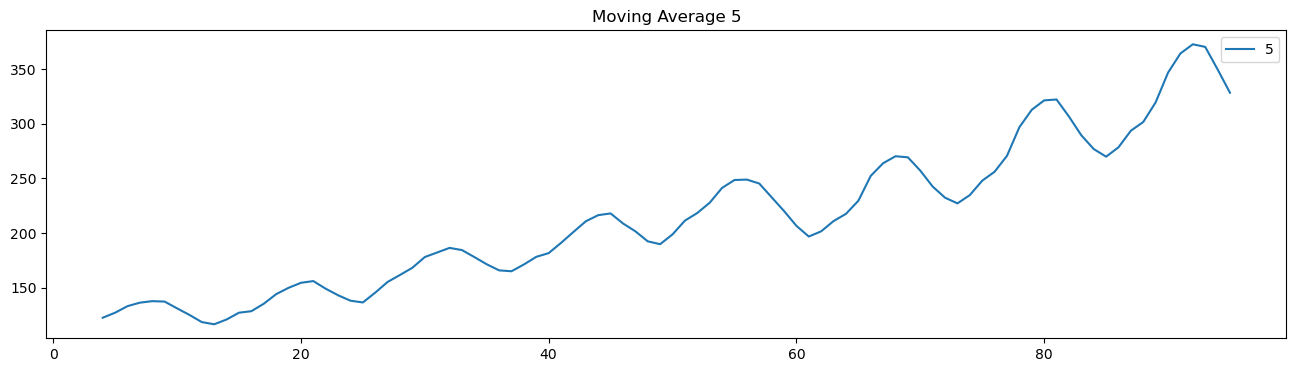

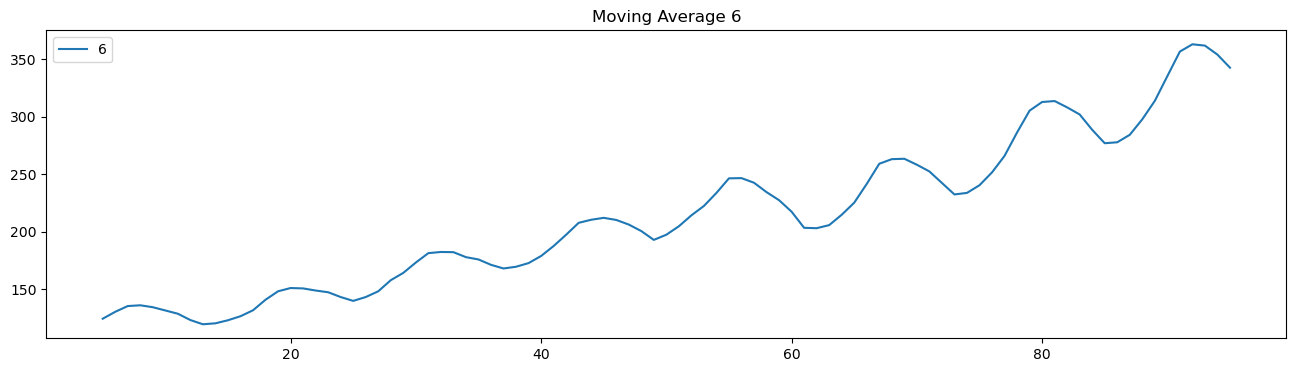

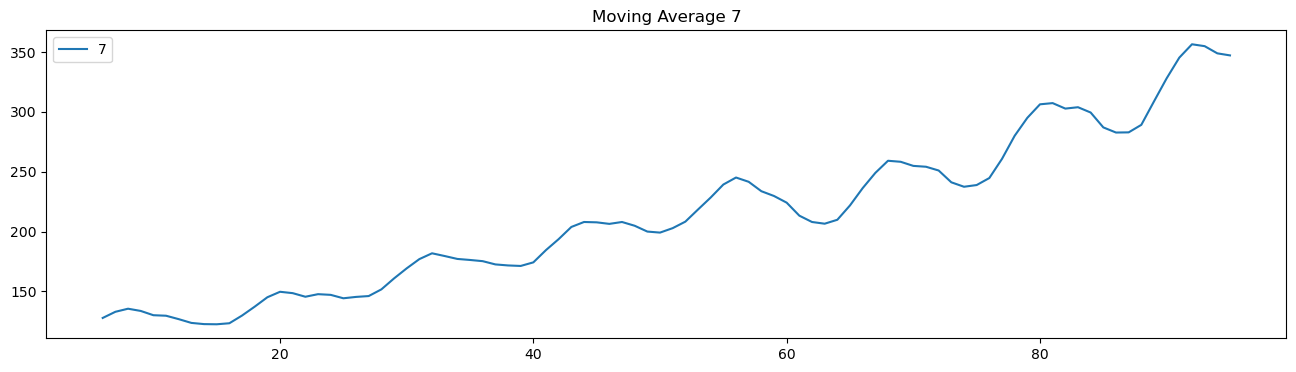

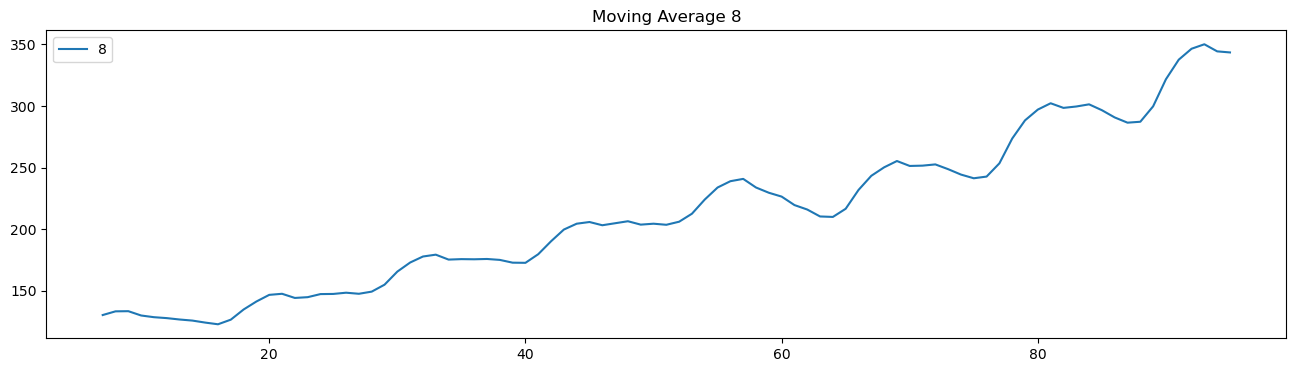

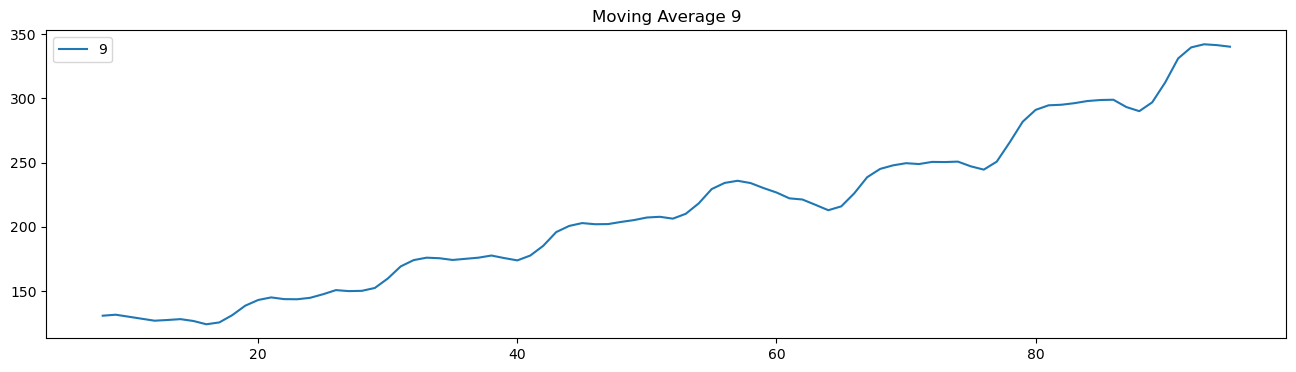

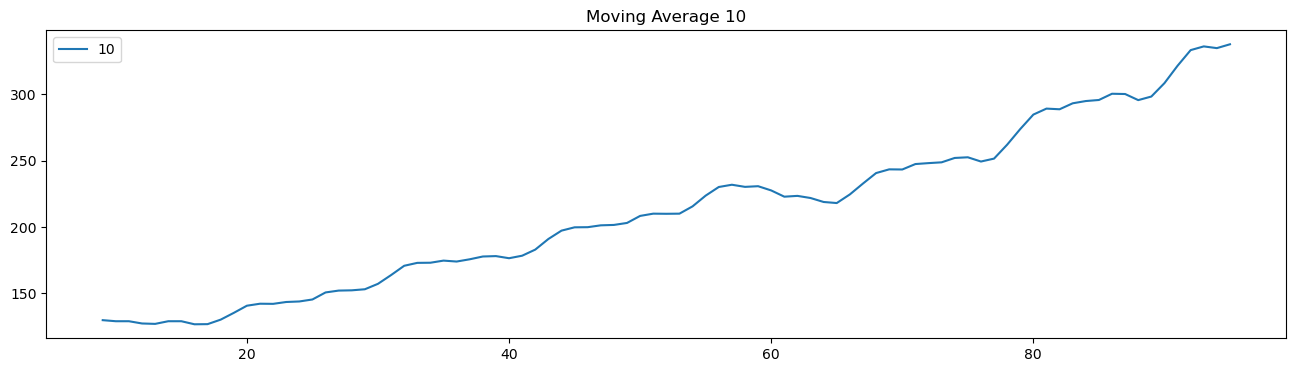

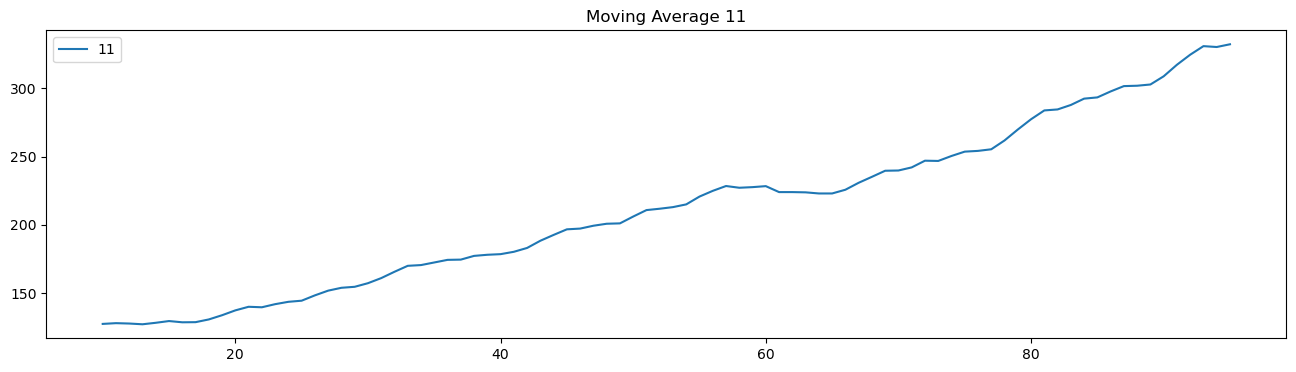

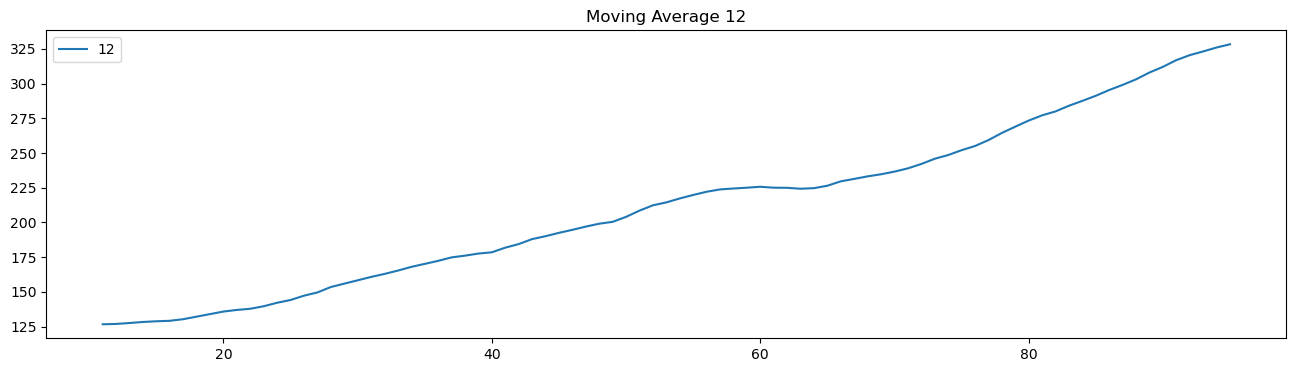

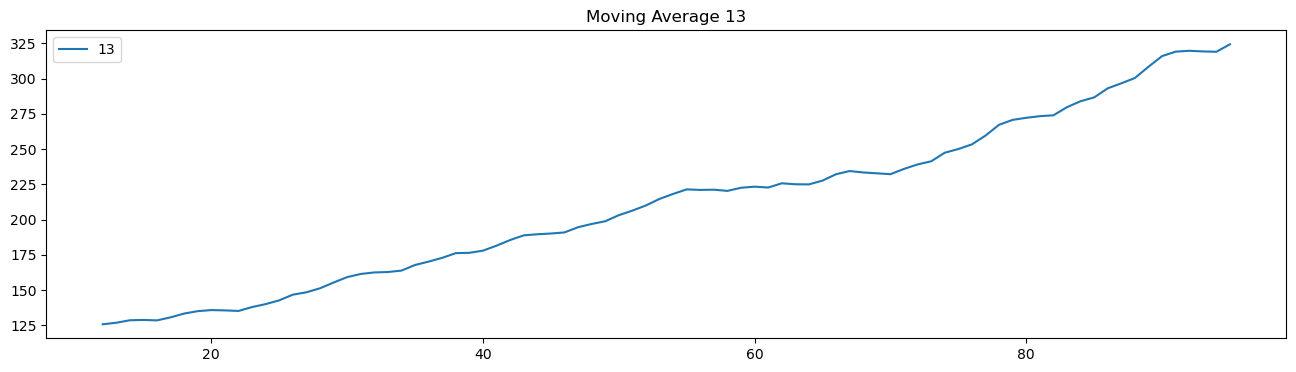

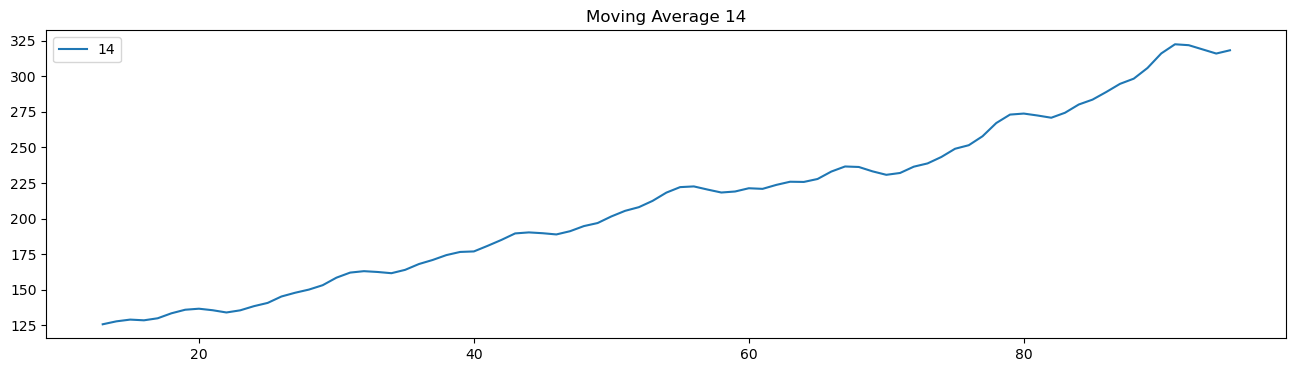

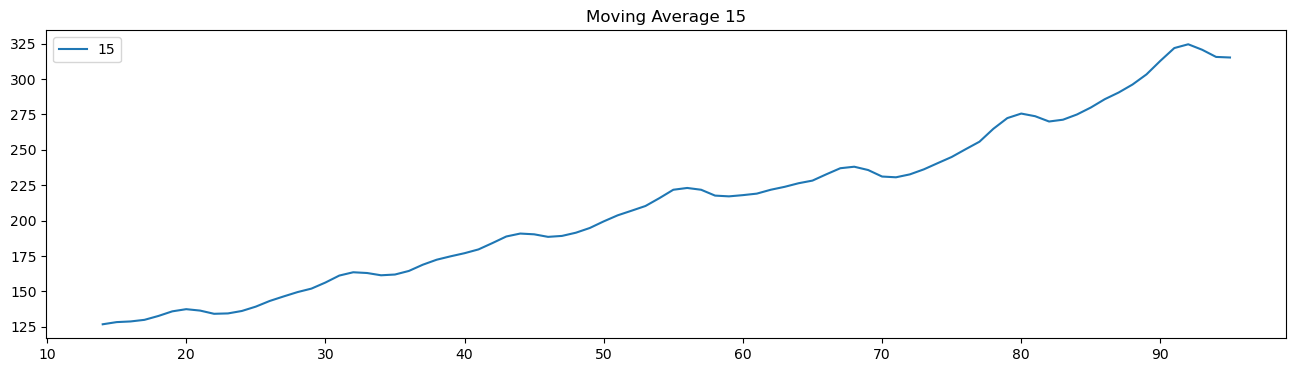

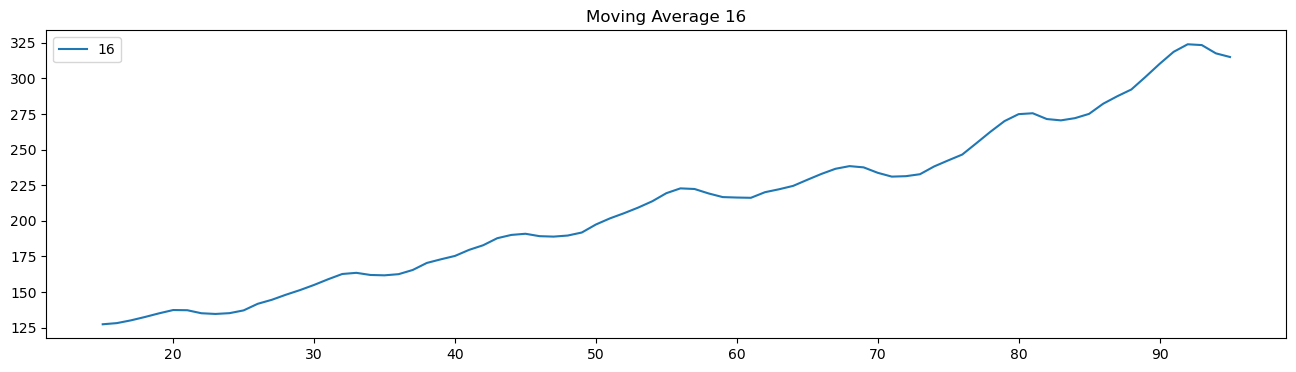

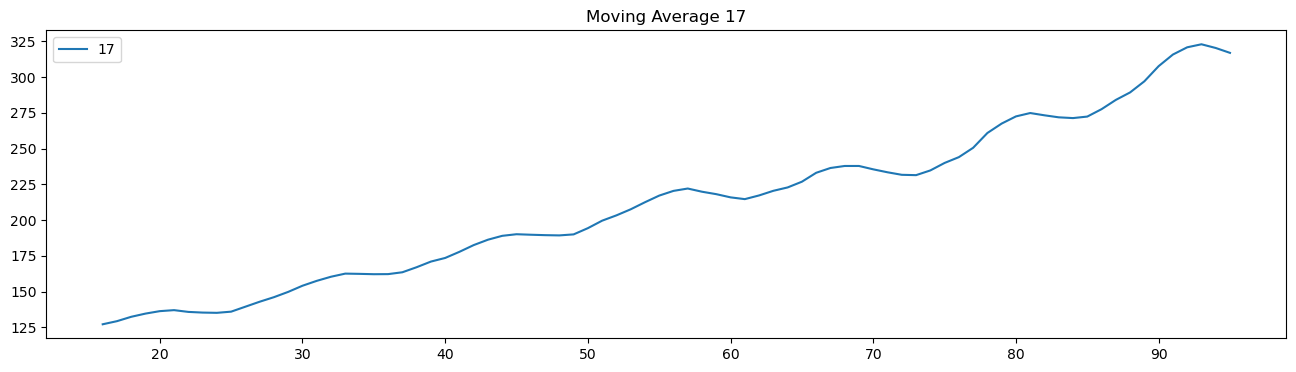

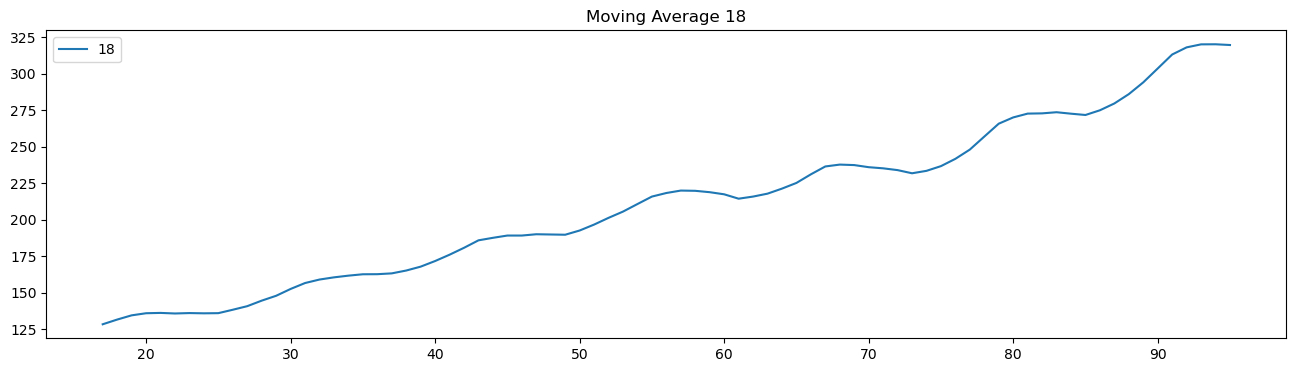

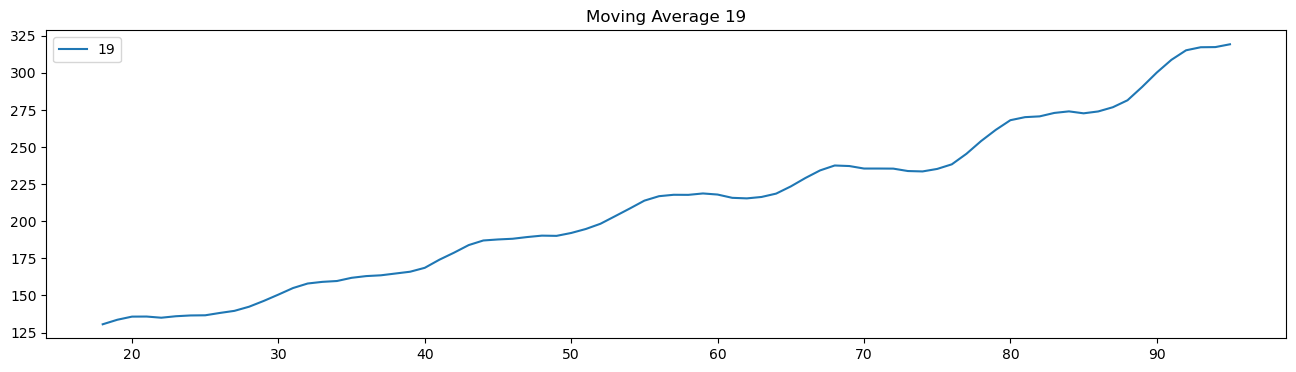

In [147]:
#moving average with independent trends 
plt.figure(figsize=(16,4))
df.Passengers.plot(label="org")
plt.title("Original Series")
for i in range(5,20):
    plt.figure(figsize=(16,4))
    df["Passengers"].rolling(i).mean().plot(label=str(i))
    plt.title("Moving Average "+str(i))
    plt.legend(loc='best')
    plt.show()

We can observe from above plots that from original day every fifth day there is a fluctuation with rise in passengers and from the other day again the rate of passengers dips down to next 5 days with a rise again,for longer term we can say that the rise in passengers will be higher in future

In [148]:
#Time series decomposition plot with plotly additive

ts = df.Passengers

result = seasonal_decompose(ts, model='additive', period=15)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ts.index, y=ts, name='Original'))

fig.add_trace(go.Scatter(x=result.trend.index, y=result.trend, name='Trend'))

fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'))

fig.add_trace(go.Scatter(x=result.resid.index, y=result.resid, name='Residual'))

fig.update_layout(
    title='Decomposition Plot',
    xaxis_title='Date',
    yaxis_title='Value',
)

fig.show()


In [149]:
#Time series decomposition plot with plotly multiplicative

ts = df.Passengers

result = seasonal_decompose(ts, model='multiplicative', period=15)

fig = go.Figure()

fig.add_trace(go.Scatter(x=ts.index, y=ts, name='Original'))

fig.add_trace(go.Scatter(x=result.trend.index, y=result.trend, name='Trend'))

fig.add_trace(go.Scatter(x=result.seasonal.index, y=result.seasonal, name='Seasonal'))

fig.add_trace(go.Scatter(x=result.resid.index, y=result.resid, name='Residual'))

fig.update_layout(
    title='Decomposition Plot',
    xaxis_title='Date',
    yaxis_title='Value',
)

fig.show()


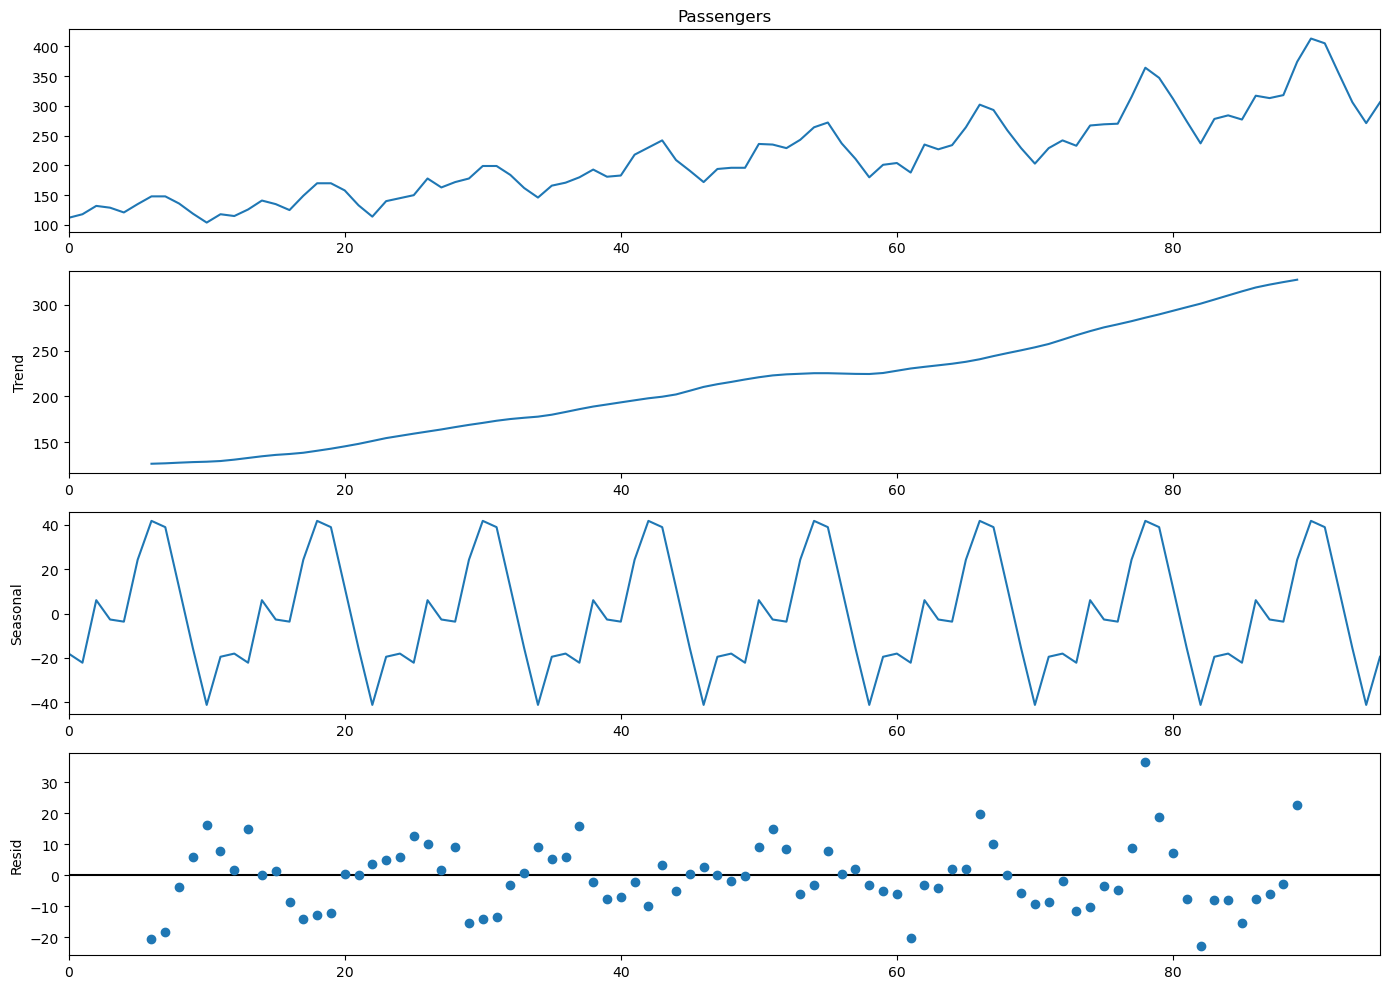

In [150]:
#decomposition plot wit matplotlib
decompose_ts_add = seasonal_decompose(df.Passengers,period=12)
with plt.rc_context():
    plt.rc("figure", figsize=(14,10))
    decompose_ts_add.plot()
    plt.show()

We observe that we got an upward trend,we observe no fluctuation in our seasonal graph ,whether yearly ,quarterly or monthly,also the residuals have some kind of irregularities 

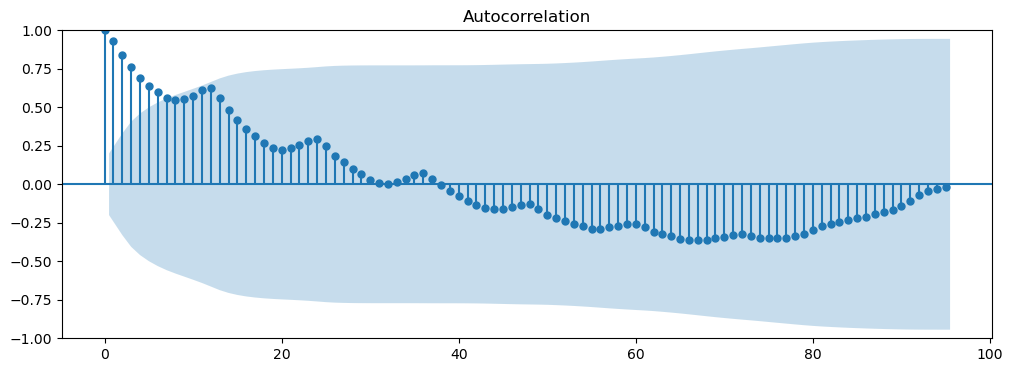

In [151]:
##ACF Plot 
with plt.rc_context():
    plt.rc("figure", figsize=(12,4))
    tsa_plots.plot_acf(df.Passengers,lags=95)
    plt.show()


C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



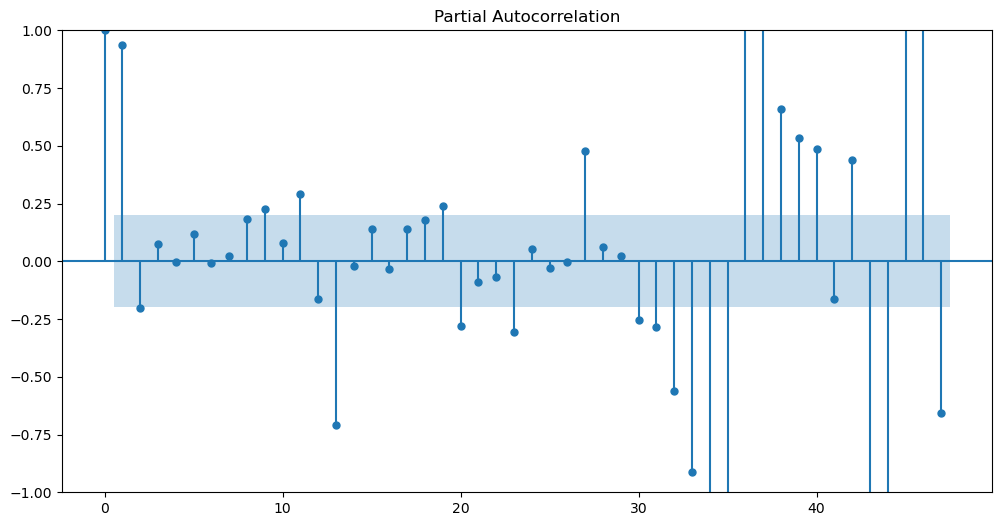

In [152]:
# PACF Plot    
with plt.rc_context():
    plt.rc("figure", figsize=(12,6))
    tsa_plots.plot_pacf(df.Passengers,lags=47)
    plt.show()

a partial autocorrelation function captures a direct correlation between time series and a lagged version of itself. and we can see clearly which points are cumulative to enhance accuracy of our forecasting 

In [153]:
#extracting the columns
df['week'] = df['Date'].dt.isocalendar().week
df['quarter']= df['Date'].dt.quarter
df ['Day']= df['Date'].dt.day_name()

In [154]:
df.drop(['Date'],axis =1,inplace=True)

In [155]:
df.Year.unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002], dtype=int64)

In [156]:
#calculating for passengers per week 
df['Passengers_week'] = df.Passengers/4.33

In [157]:
df

Passengers Month  Year  week  quarter        Day  Passengers_week
0          112   Jan  1995    52        1     Sunday        25.866051
1          118   Feb  1995     5        1  Wednesday        27.251732
2          132   Mar  1995     9        1  Wednesday        30.484988
3          129   Apr  1995    13        2   Saturday        29.792148
4          121   May  1995    18        2     Monday        27.944573
..         ...   ...   ...   ...      ...        ...              ...
91         405   Aug  2002    31        3   Thursday        93.533487
92         355   Sep  2002    35        3     Sunday        81.986143
93         306   Oct  2002    40        4    Tuesday        70.669746
94         271   Nov  2002    44        4     Friday        62.586605
95         306   Dec  2002    48        4     Sunday        70.669746

[96 rows x 7 columns]

In [158]:
#plotting for week wise report 
fig = px.bar(df, x='Passengers_week', y='week',
             hover_data=['Passengers_week', 'Month'], color='Passengers',
              height=400)
fig.show()

We observe that in our weekly report in the year 2002 and 2001 we had highest number passengers,the month of june,july and august the pattern of passengers has a rise 

In [159]:
#day analysis of passengers 
df['passengers_day']= df.Passengers_week/7

In [160]:
#plotting for trends and patterns for daily patterns for last 7 years 
fig = px.bar(df, x="passengers_day", y="Day", text="Year",color='Passengers',orientation='h')
fig.show()

If we look and observe the pattern from last 7 years we see that every thursday ,friday and moday the count of passengers have gone higher which indicates that we have frequent flyers on weekends and return flights, this also indicates that the rise of passengers is higher on weekends and again dip from tuesday with rise from thursday 

In [161]:
#splitting our train and test data,leaving test data with two year of time series 
size = 72
train = df1[:size]
test =  df1[size:]

In [162]:
train.head()


Passengers
Date                  
1995-01-01         112
1995-02-01         118
1995-03-01         132
1995-04-01         129
1995-05-01         121

In [163]:
test.head()

Passengers
Date                  
2001-01-01         242
2001-02-01         233
2001-03-01         267
2001-04-01         269
2001-05-01         270

In [164]:
#defining mean absolute percentaage error
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

## Data driven Model Methods 

Simple Exponential Method

In [165]:
ses_model = SimpleExpSmoothing(train['Passengers']).fit(optimized=True)
test_pred_ses = ses_model.forecast(24)
train_pred_ses = ses_model.fittedvalues
test_rmse_ses = sqrt(mean_squared_error(test_pred_ses,test.Passengers))
train_rmse_ses = sqrt(mean_squared_error(train_pred_ses,train))
mape_ses = MAPE(test_pred_ses,test.Passengers)
print('Simple Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_ses),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_ses),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_ses))

Simple Exponential Method Evaluation 
 Mean Absolute Percent Error = 23.382283350044727 
 Train Root Mean Squared Error = 19.031771730910982 
 Test Root Mean Squared Error = 91.11325402904403


C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



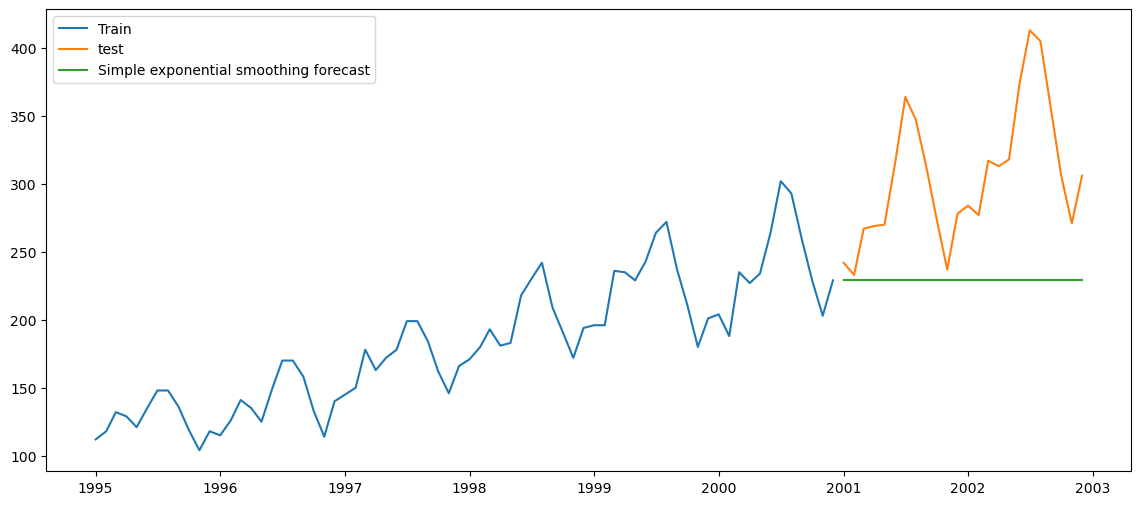

In [166]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.legend(loc='best')
plt.show()

We observe no captures of seasonality and most recent observations gets higher value compared to older records 

Holt Method (Double Exponential)

In [167]:
#fitting our values for holt method 
hm_mod = Holt(train).fit(optimized=True)
test_pred_hm = hm_mod.forecast(24)
train_pred_hm = hm_mod.fittedvalues
test_rmse_hm = sqrt(mean_squared_error(test_pred_hm,test.Passengers))
train_rmse_hm = sqrt(mean_squared_error(train_pred_hm,train))
mape_hm = MAPE(test_pred_hm,test.Passengers)
mape_hm = MAPE(test_pred_hm,test.Passengers)
print('double Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hm),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hm),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hm))



double Exponential Method Evaluation 
 Mean Absolute Percent Error = 17.148981696358685 
 Train Root Mean Squared Error = 18.96128999459111 
 Test Root Mean Squared Error = 71.63464300883933


C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



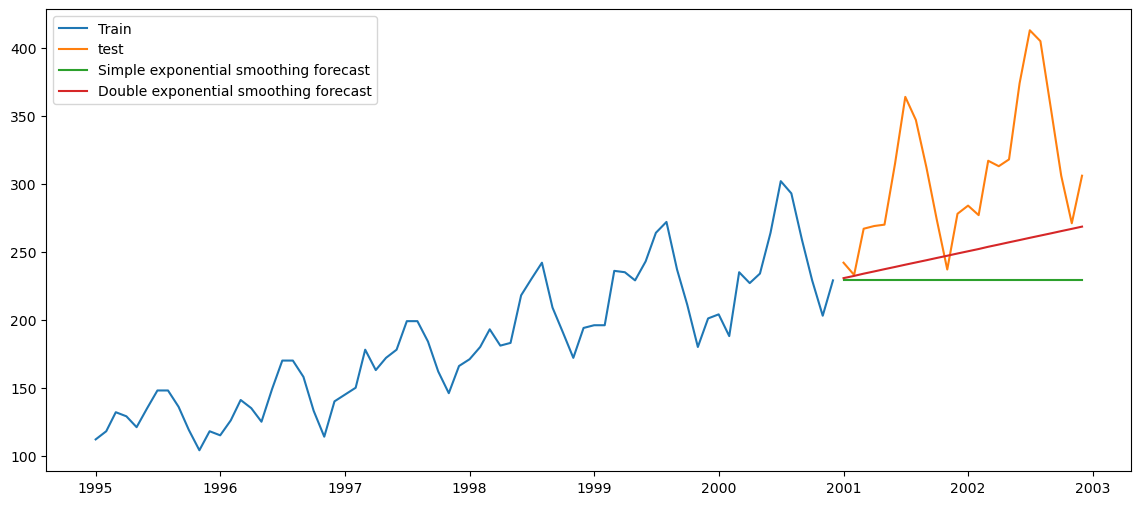

In [168]:
#plotting for holts method
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.legend(loc='best')
plt.show()


We observe that we have captured the upward trend of the data but still we werent able to capture seasonality

Holts winter exponential smoothing with additive seasonality and trend (Triple Exponential)

In [169]:
hw_mod = ExponentialSmoothing(train,seasonal="add",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hw = hw_mod.forecast(24)
train_pred_hw = hw_mod.fittedvalues
test_rmse_hw = sqrt(mean_squared_error(test_pred_hw,test.Passengers))
train_rmse_hw =sqrt(mean_squared_error(train_pred_hw,train))
mape_hw = MAPE(test_pred_hw,test.Passengers)
print('additive seasonality and trend Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hw),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hw))




additive seasonality and trend Exponential Method Evaluation 
 Mean Absolute Percent Error = 12.084508619943344 
 Train Root Mean Squared Error = 7.75130351137479 
 Test Root Mean Squared Error = 47.5692832638379


C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



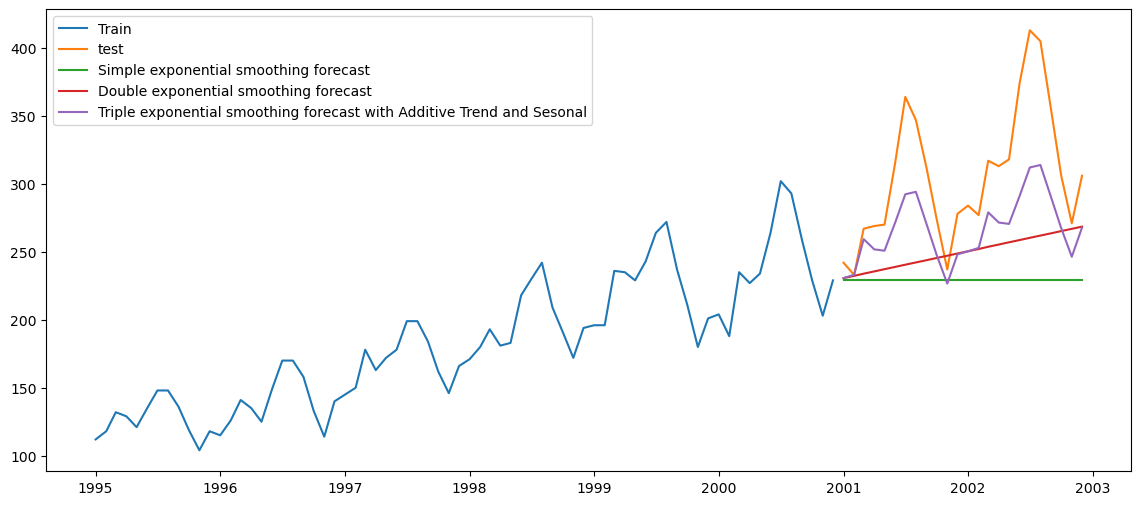

In [170]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.plot(test_pred_hw, label='Triple exponential smoothing forecast with Additive Trend and Sesonal')
plt.legend(loc='best')
plt.show()

We observe that it captures trend and also our values that are forecasting our lower compared to test values, the model also captures seasonality

Holts winter exponential smoothing with multiplicative seasonality and additive trend (Triple Exponential)

In [171]:
hw_mod_mul = ExponentialSmoothing(train,seasonal="mul",trend="add",seasonal_periods=12).fit(optimized=True)
test_pred_hw_mul = hw_mod_mul.forecast(24)
train_pred_hw_mul = hw_mod_mul.fittedvalues
test_rmse_hw_mul = sqrt(mean_squared_error(test_pred_hw_mul,test.Passengers))
train_rmse_hw_mul =sqrt(mean_squared_error(train_pred_hw_mul,train))
mape_hw_mul = MAPE(test_pred_hw_mul,test.Passengers)
print('Multiplicative seasonality and additive trend Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hw_mul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw_mul),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hw_mul))




C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Multiplicative seasonality and additive trend Exponential Method Evaluation 
 Mean Absolute Percent Error = 9.368354573562144 
 Train Root Mean Squared Error = 6.386634437793857 
 Test Root Mean Squared Error = 34.989365374325125


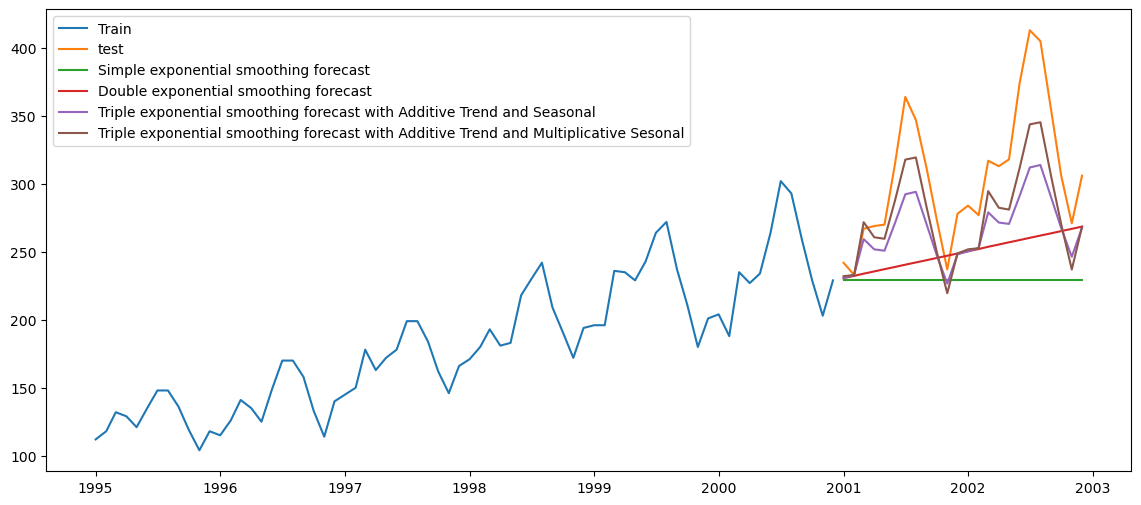

In [172]:
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.plot(test_pred_hw, label='Triple exponential smoothing forecast with Additive Trend and Seasonal')
plt.plot(test_pred_hw_mul, label='Triple exponential smoothing forecast with Additive Trend and Multiplicative Sesonal')
plt.legend(loc='best')
plt.show()

We observe that errors have drastically lowered and we are able to capture level,trend and seasonality altogether

Holts winter exponential smoothing with multiplicative seasonality and multiplicative trend (Triple Exponential)

In [173]:
hw_mod_mul_mul = ExponentialSmoothing(train,seasonal="mul",trend="mul",seasonal_periods=12).fit(optimized=True)
test_pred_hw_mul_mul = hw_mod_mul_mul.forecast(24)
train_pred_hw_mul_mul = hw_mod_mul_mul.fittedvalues
test_rmse_hw_mul_mul = sqrt(mean_squared_error(test_pred_hw_mul_mul,test.Passengers))
train_rmse_hw_mul_mul =sqrt(mean_squared_error(train_pred_hw_mul_mul,train))
mape_hw_mul_mul = MAPE(test_pred_hw_mul_mul,test.Passengers)
print('multiplicative seasonality and multiplicative trend Exponential Method Evaluation',"\n",\
      'Mean Absolute Percent Error = {}'.format(mape_hw_mul_mul),"\n",\
'Train Root Mean Squared Error = {}'.format(train_rmse_hw_mul_mul),"\n",
'Test Root Mean Squared Error = {}'.format(test_rmse_hw_mul_mul))




multiplicative seasonality and multiplicative trend Exponential Method Evaluation 
 Mean Absolute Percent Error = 6.034483884370218 
 Train Root Mean Squared Error = 6.3967514247667365 
 Test Root Mean Squared Error = 23.05679851513917


C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul



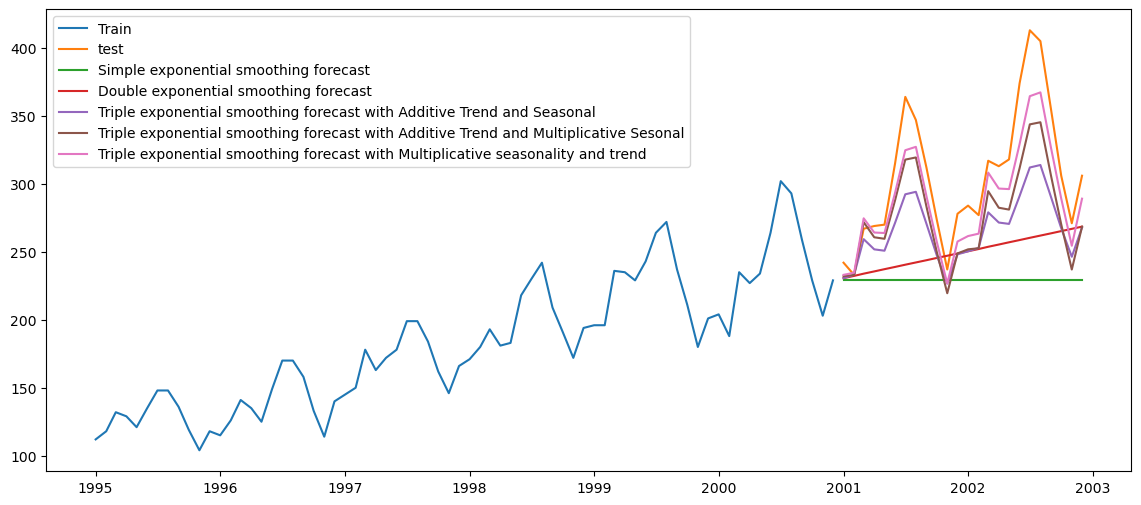

In [174]:
#plotting for both multiplicative trend and seasonality
plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='test')
plt.plot(test_pred_ses, label='Simple exponential smoothing forecast')
plt.plot(test_pred_hm, label='Double exponential smoothing forecast')
plt.plot(test_pred_hw, label='Triple exponential smoothing forecast with Additive Trend and Seasonal')
plt.plot(test_pred_hw_mul, label='Triple exponential smoothing forecast with Additive Trend and Multiplicative Sesonal')
plt.plot(test_pred_hw_mul_mul,label ="Triple exponential smoothing forecast with Multiplicative seasonality and trend")
plt.legend(loc='best')
plt.show()

In [175]:

Results = {"Models":pd.Series(["Simple_Exp","holt method","holt winter","holt_mul_ad","holt_mul_mul"\
                                  ]),\
        "Train_RMSE":pd.Series([train_rmse_ses,train_rmse_hm,train_rmse_hw,train_rmse_hw_mul,train_rmse_hw_mul_mul]),\
        "Test_MAPE(%)":pd.Series([mape_ses,mape_hm,mape_hw,mape_hw_mul,mape_hw_mul_mul]),\
        "Test_RMSE_Values":pd.Series([test_rmse_ses,test_rmse_hm,test_rmse_hw,test_rmse_hw_mul,test_rmse_hw_mul_mul])}
table_evaluation=pd.DataFrame(Results)
table_evaluation.sort_values(['Test_MAPE(%)'], inplace=True, ignore_index=True)
table_evaluation

Models  Train_RMSE  Test_MAPE(%)  Test_RMSE_Values
0  holt_mul_mul    6.396751      6.034484         23.056799
1   holt_mul_ad    6.386634      9.368355         34.989365
2   holt winter    7.751304     12.084509         47.569283
3   holt method   18.961290     17.148982         71.634643
4    Simple_Exp   19.031772     23.382283         91.113254

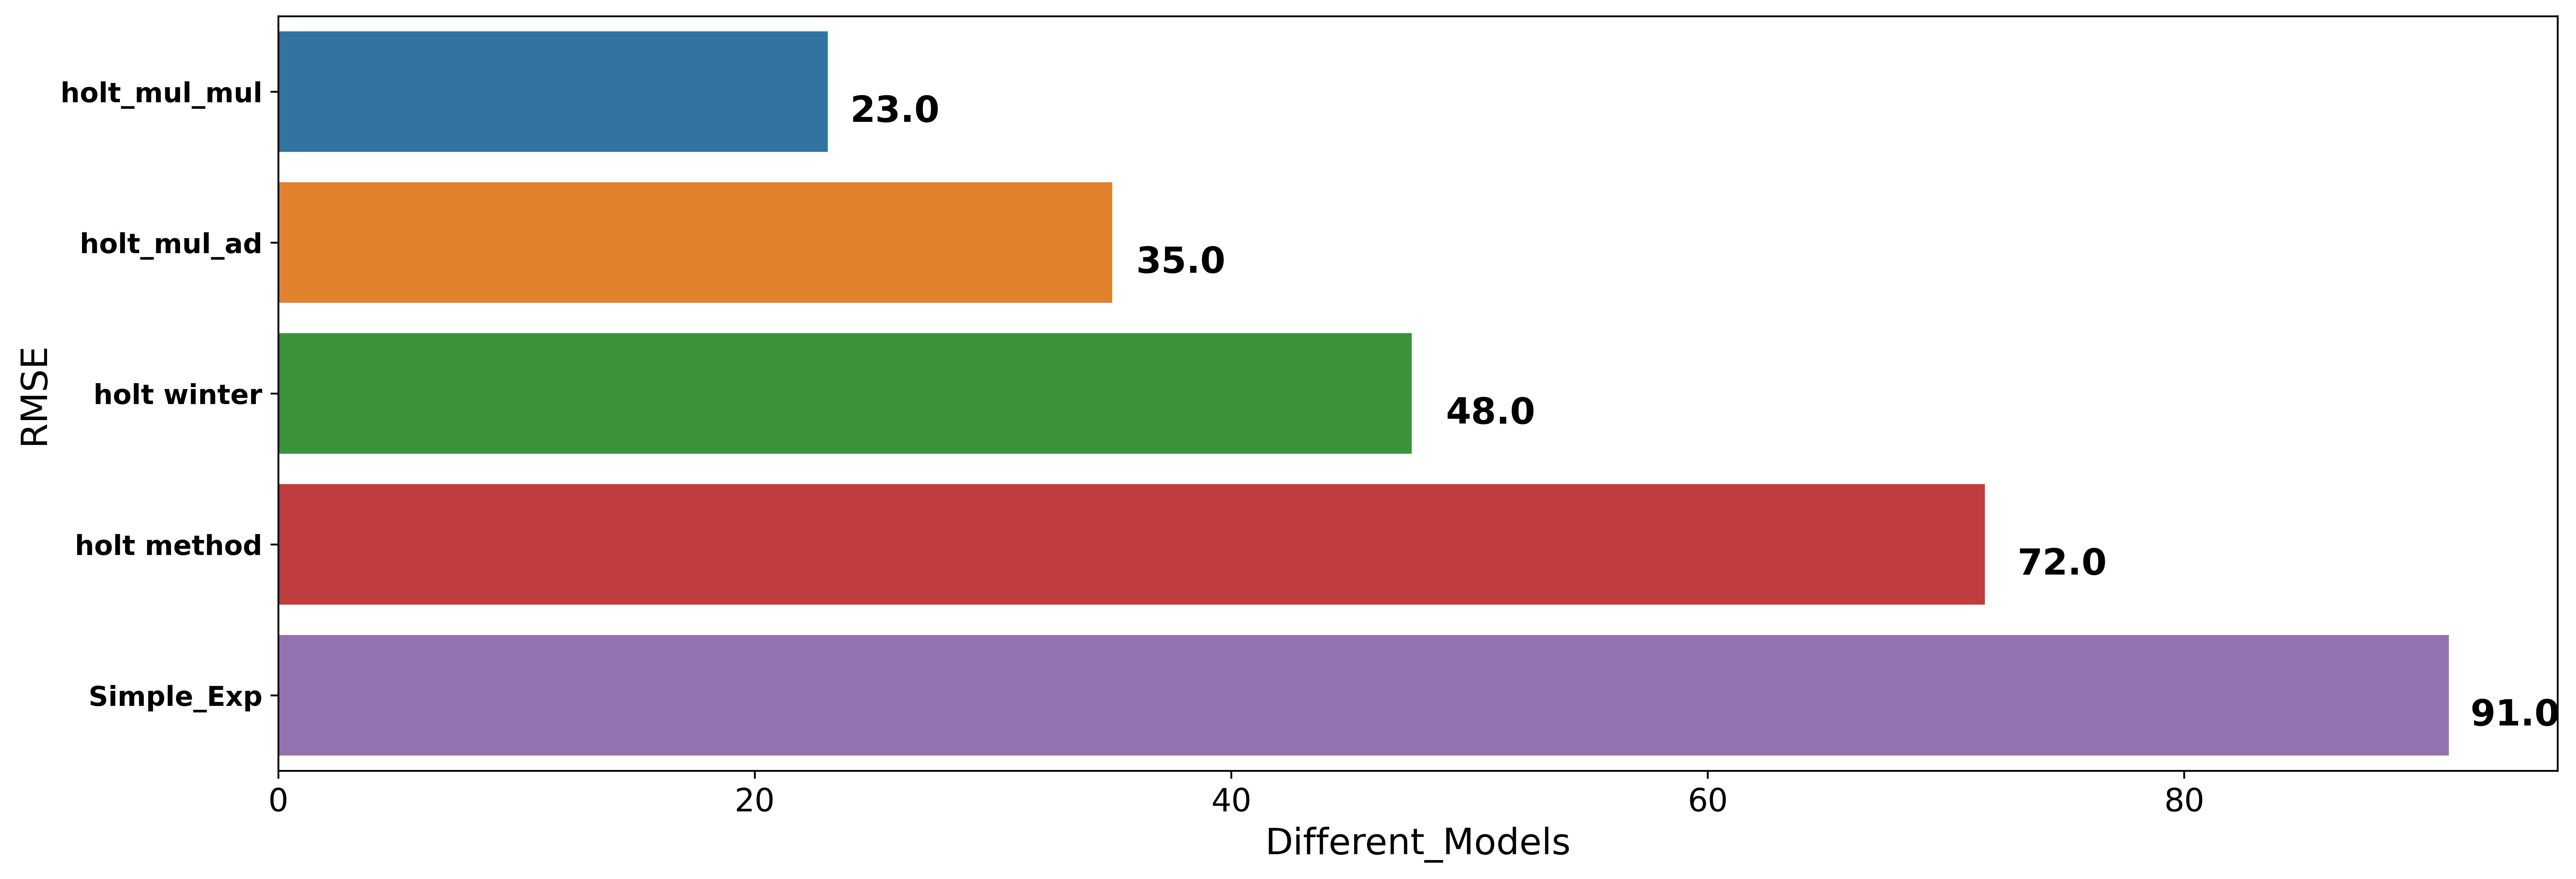

In [176]:
f, axe = plt.subplots(1,1, figsize=(18,6), dpi=500)
sn.barplot(x='Test_RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.Test_RMSE_Values.values,0)):
    axe.text(v + 1, i + .20, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)



In [177]:
#fitting our model for predictions with multiplicative trend and multiplicative seasonality
pred_model_mul_mul = ExponentialSmoothing(df1.Passengers,seasonal="mul",trend ="mul",seasonal_periods=12).fit()

C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

C:\Users\Adith\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning:

overflow encountered in matmul



## Autoregressive Integrated Moving Averages (ARIMA)

Test of stationarity

In [178]:
def test_stationarity(timeseries):
    
    #Determine rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


Augmented Dicky Fuller Test
Null Hypothesis (H0): The series is not stationary

p-val > 0.05

Alternate Hypothesis (H1): The series is stationary

p-val <= 0.05

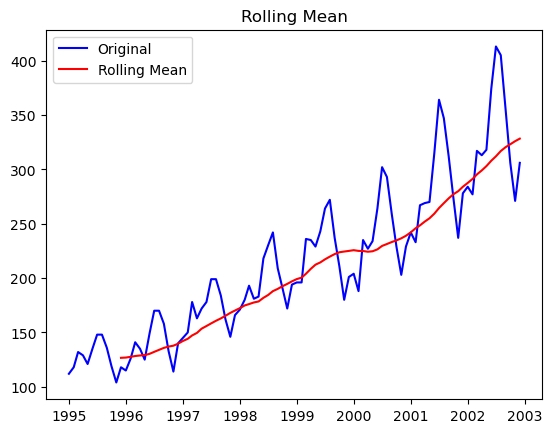

Results of Dickey Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [179]:
#plotting to check the rolling mean 
sales= pd.DataFrame()
sales['Passengers'] = df1[['Passengers']]
test_stationarity(sales)

In [180]:
#testing with adfuller with significant value
def adf_test(series):    
    result = adfuller(series.dropna())  
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    #for key,val in result[4].items():
        #out[f'critical value ({key})']=val
    if result[1] <= 0.05:
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

In [181]:
adf_test(sales)

Fail to reject the null hypothesis
Data is non-stationary


Since our data failed to accept the null hypothesis and our data is non-stationary as we know that for ARIMA model data has to be stationary we need to transform and also check with differencing 

## Feature Scaling

Square root Transformation

In [182]:
sqr_root = pd.DataFrame()
sqr_root = df1[['Passengers']]
sqr_root['Passengers'] = np.sqrt(sqr_root.Passengers)

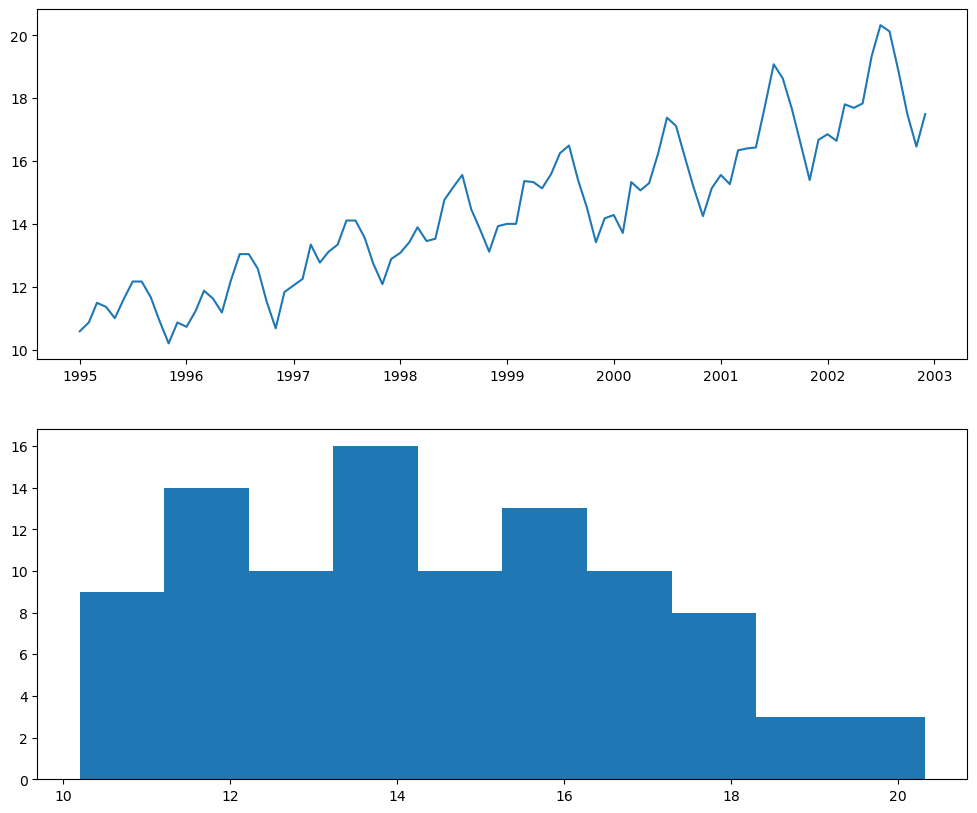

In [183]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(sqr_root['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(sqr_root['Passengers'])
plt.show()


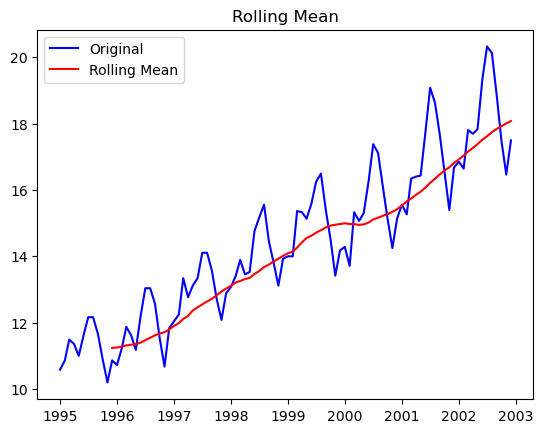

Results of Dickey Fuller Test:
Test Statistic                  0.451435
p-value                         0.983320
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [184]:
test_stationarity(sqr_root)

In [185]:
adf_test(sqr_root)

Fail to reject the null hypothesis
Data is non-stationary


Log Transformation

In [186]:
log = pd.DataFrame()
log = df1[['Passengers']]
log['Passengers'] = np.log(log.Passengers)


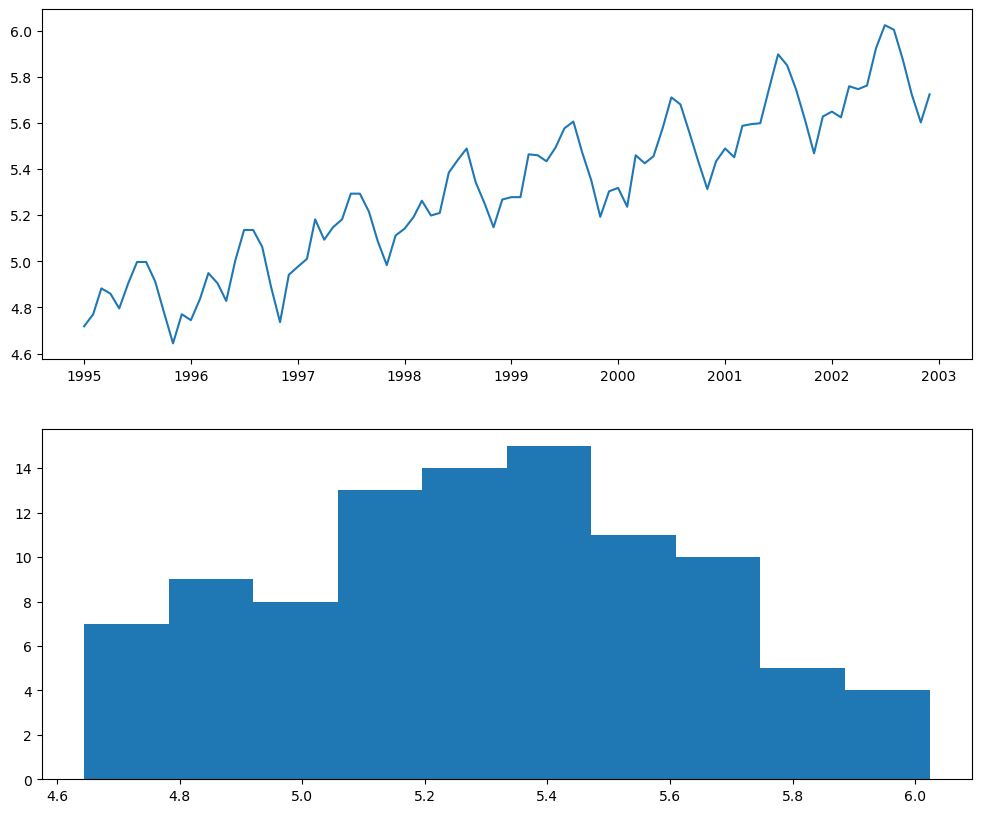

In [187]:
# line chart
fig=plt.figure(figsize=(12,10))
plt.subplot(211)
plt.plot(log['Passengers'])
#Histogram
plt.subplot(212)
plt.hist(log['Passengers'])
plt.show()


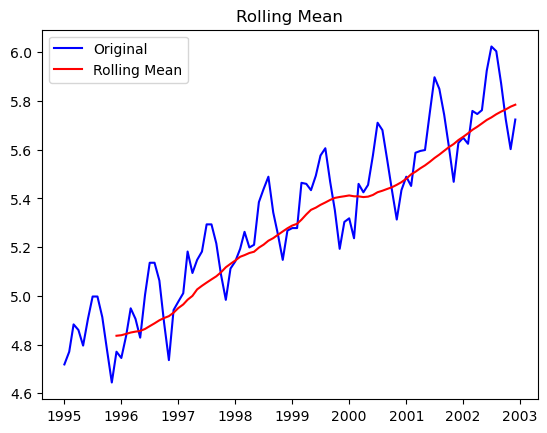

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [188]:
test_stationarity(log)

In [189]:
adf_test(log)

Fail to reject the null hypothesis
Data is non-stationary


Converting Non-Stationary Time Series into Stationary

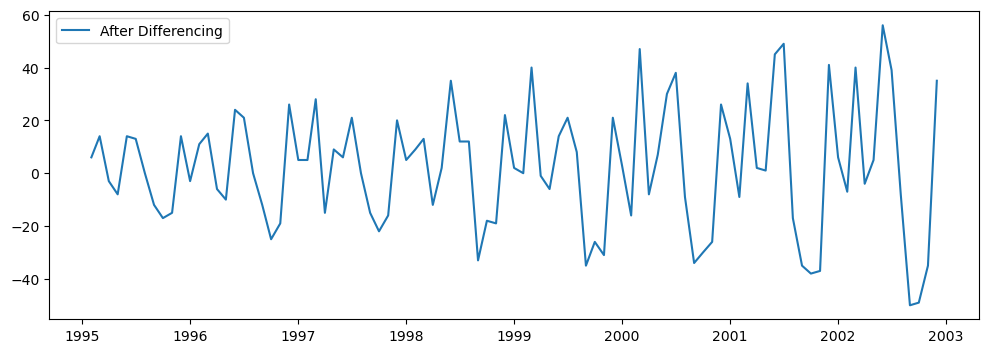

In [190]:
#applying differencing on our data 
diff = df1 - df1.shift(1)
diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(diff, label='After Differencing')
plt.legend(loc='best')
plt.show()

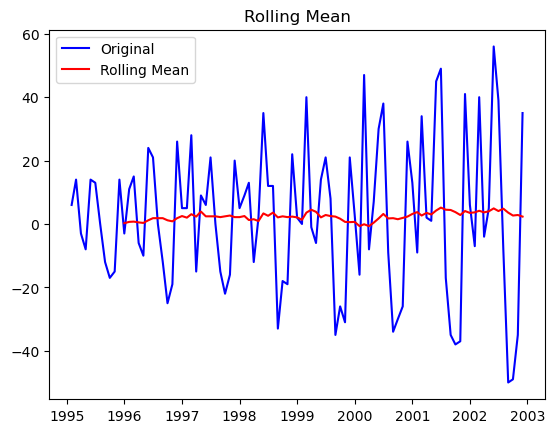

Results of Dickey Fuller Test:
Test Statistic                 -2.150002
p-value                         0.224889
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [191]:
test_stationarity(diff)

In [192]:
adf_test(diff)

Fail to reject the null hypothesis
Data is non-stationary


Seasonal Differencing

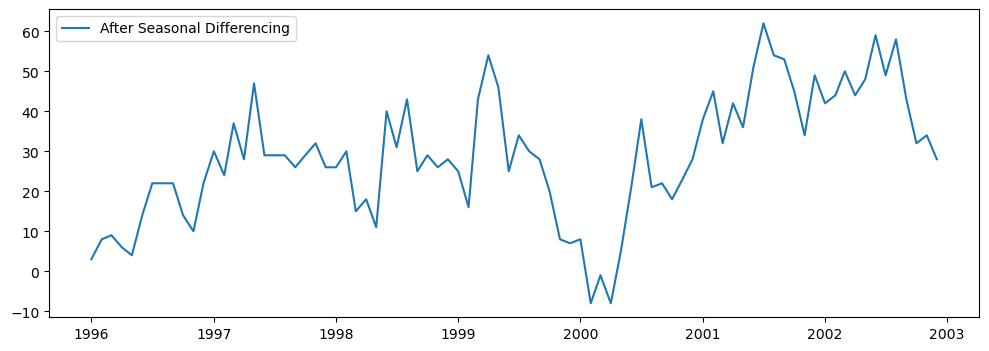

In [193]:
s_diff = df1 - df1.shift(12)
s_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(s_diff, label='After Seasonal Differencing')
plt.legend(loc='best')
plt.show()

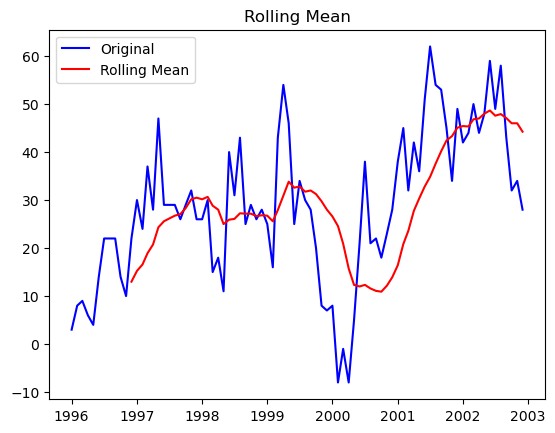

Results of Dickey Fuller Test:
Test Statistic                 -2.690004
p-value                         0.075784
#Lags Used                      1.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [194]:
test_stationarity(s_diff)

In [195]:
adf_test(s_diff)

Fail to reject the null hypothesis
Data is non-stationary


Transformation Differencing

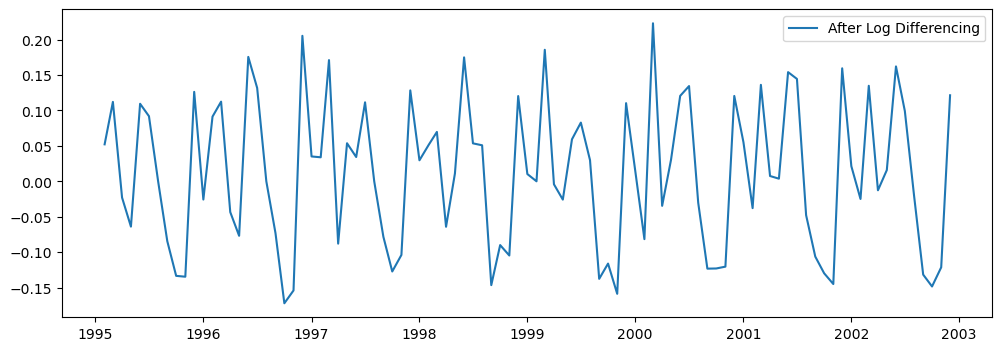

In [196]:
log_diff = log - log.shift(1)
log_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(log_diff, label='After Log Differencing')
plt.legend(loc='best')
plt.show()

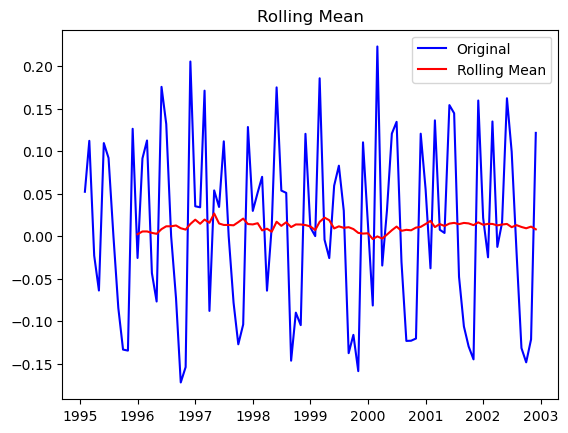

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [197]:
test_stationarity(log_diff)

In [200]:
adf_test(log_diff)

Fail to reject the null hypothesis
Data is non-stationary


Box Cox Transformation

Passengers
Date                  
1995-01-01    4.718499
1995-02-01    4.770685
1995-03-01    4.882802
1995-04-01    4.859812
1995-05-01    4.795791

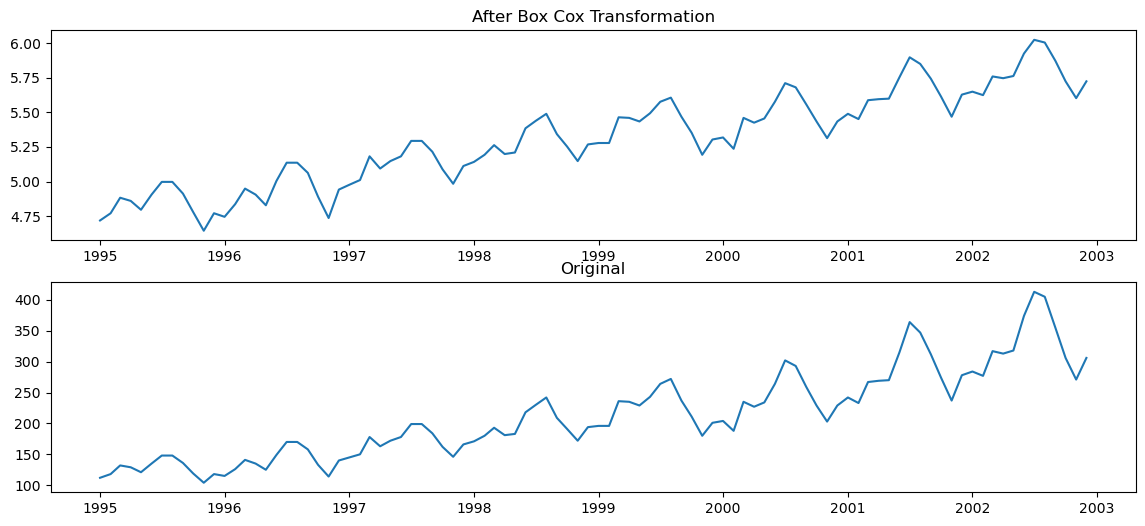

In [203]:
df_boxcox = pd.DataFrame()
df_boxcox['Passengers'] = pd.Series(boxcox(df1['Passengers'], lmbda=0), df1.index)
display(df_boxcox.head())
fig, axis = plt.subplots(2,figsize=(14,6),)
axis[0].plot(df_boxcox)
axis[0].set_title('After Box Cox Transformation')
axis[1].plot(df1, label='original')
axis[1].set_title('Original')
plt.show()

We observe that the variance in earlier and later years is constant,but since the graph has an upward trend it indicates that our mean is not yet constant , therefore we have to go ahead with differencing

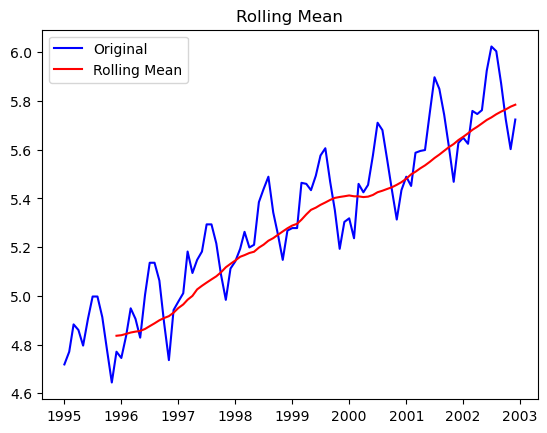

Results of Dickey Fuller Test:
Test Statistic                 -0.723027
p-value                         0.840695
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [204]:
test_stationarity(df_boxcox)

In [206]:
adf_test(df_boxcox)

Fail to reject the null hypothesis
Data is non-stationary


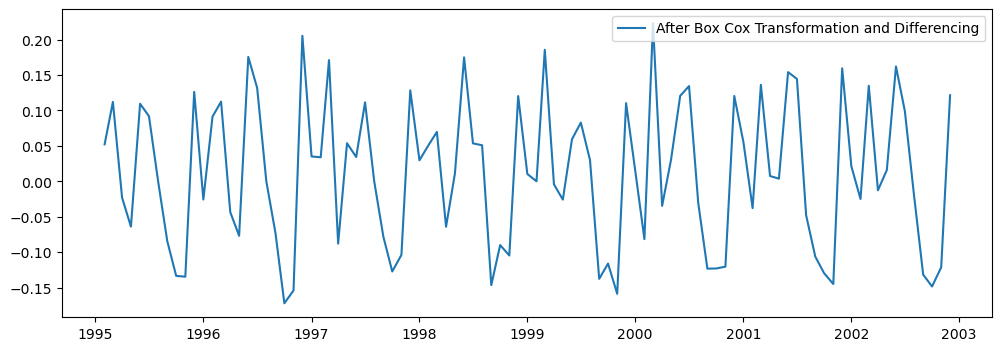

In [207]:
# data_boxcox - data_boxcox.shift() :- Performs difference between the previous and current observations.
#data_boxcox_diff = data_boxcox - data_boxcox.shift()
df_boxcox_diff = df_boxcox - df_boxcox.shift()
df_boxcox_diff.dropna(inplace=True)
plt.figure(figsize=(12,4))
plt.plot(df_boxcox_diff, label='After Box Cox Transformation and Differencing')
plt.legend(loc='best')
plt.show()

After differencing we have cut down trends,a horizontal trend and even the mean is constant,with variance almost to constant

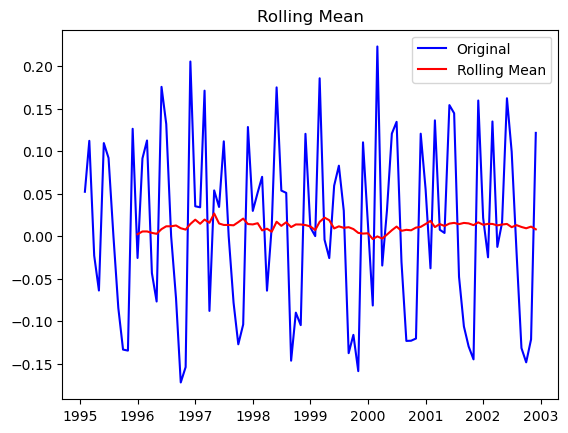

Results of Dickey Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [208]:
#check this boxcox transfered data with function
test_stationarity(df_boxcox_diff)

In [242]:
adf_test(df_boxcox_diff)

Fail to reject the null hypothesis
Data is non-stationary


Now we can go ahead with AR forecasting as we have achieved Maximum stationary for AR forecasting 

## Hyperparameter tuning for ARIMA

In [243]:
# grid search ARIMA parameters for a time series

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
# prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.70)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
# make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
# calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

In [333]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_model(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    #print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except Exception as e:
                    print(e)
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [334]:
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 5 )
q_values = range(0, 5 )

evaluate_model(df_boxcox_diff.Passengers, p_values, d_values, q_values)

Best ARIMA(4, 1, 4) RMSE=0.075


In [276]:
#building timeseries model with optimal parameters 
train_boxcox = df_boxcox[:size]
test_boxcox = df_boxcox[size:]
train_boxcox_diff = df_boxcox_diff[:size]
test_boxcox_diff = df_boxcox_diff[size:]

Inverse transformation of the Box-Cox Differencing

In [277]:
model = ARIMA(train_boxcox_diff,order=(4,1,4))
model_fit = model.fit()
y_hat_ar = df_boxcox_diff.copy()
y_hat_ar['arima_forecast'] = model_fit.predict(df_boxcox_diff.index.min(), df_boxcox_diff.index.max())
# We did differencing. So we need to revert it by adding the consecutive observations.
# For that we are using cumsum() method
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].cumsum()
# We removed the first observations after differencing as it was null. Hence, adding the first observation back.
y_hat_ar['arima_forecast'] = y_hat_ar['arima_forecast'].add(df_boxcox.Passengers[0])
# Now doing the reverse transformation 
# We have done Box Cox Log Log transformation with lambda = 0
# Hence, we have to the exponential as it is the reverse of the log.
y_hat_ar['arima_forecast'] = np.exp(y_hat_ar['arima_forecast'])

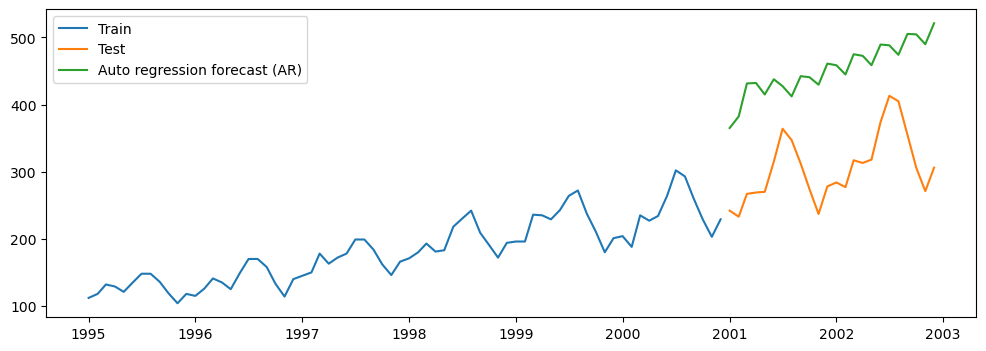

In [278]:
#plotting our arima model
plt.figure(figsize=(12,4))
plt.plot(train['Passengers'], label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_ar['arima_forecast'][test.index.min():], label='Auto regression forecast (AR)')
plt.legend(loc='best')
plt.show()

We observe that we couldnt capture seasonality only we have detected trend,and even our model has performed moderately well 

In [279]:
rmse_ARIMA = np.sqrt(mean_squared_error(test, y_hat_ar['arima_forecast'][test.index.min():])).round(2)
rmse_ARIMA

152.69

In [280]:
mape_arima = round(np.mean(np.abs((test.Passengers - y_hat_ar['arima_forecast'][test.index.min():])/test.Passengers)*100),2)
mape_arima

50.3

We have a conclusion that our model has done well but not better than holts method,but we cannot compare to holts method as it captures seasonality

Analysing the residuals 

In [281]:
## residuals must be closer to zero or zero ##

In [282]:
model_residual = model_fit.resid
model_residual.mean()

-0.00571049506170393

In [283]:
##residuals must be stationary ##

In [284]:
adf_test(model_residual)

Fail to reject the null hypothesis
Data is non-stationary


In [285]:
## no autocorrelaton between the residuals ##

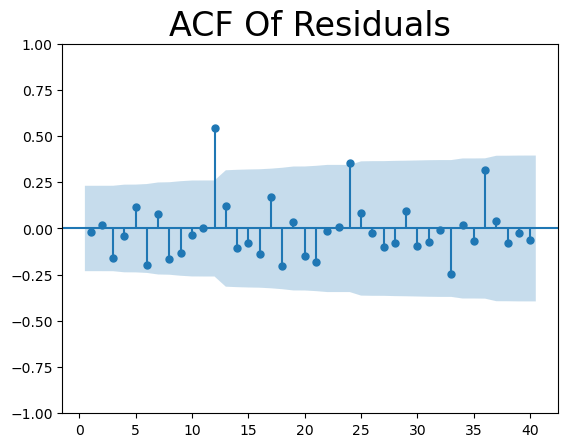

In [286]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals",size=24)
plt.show()

In [287]:
## residuals must be random ##

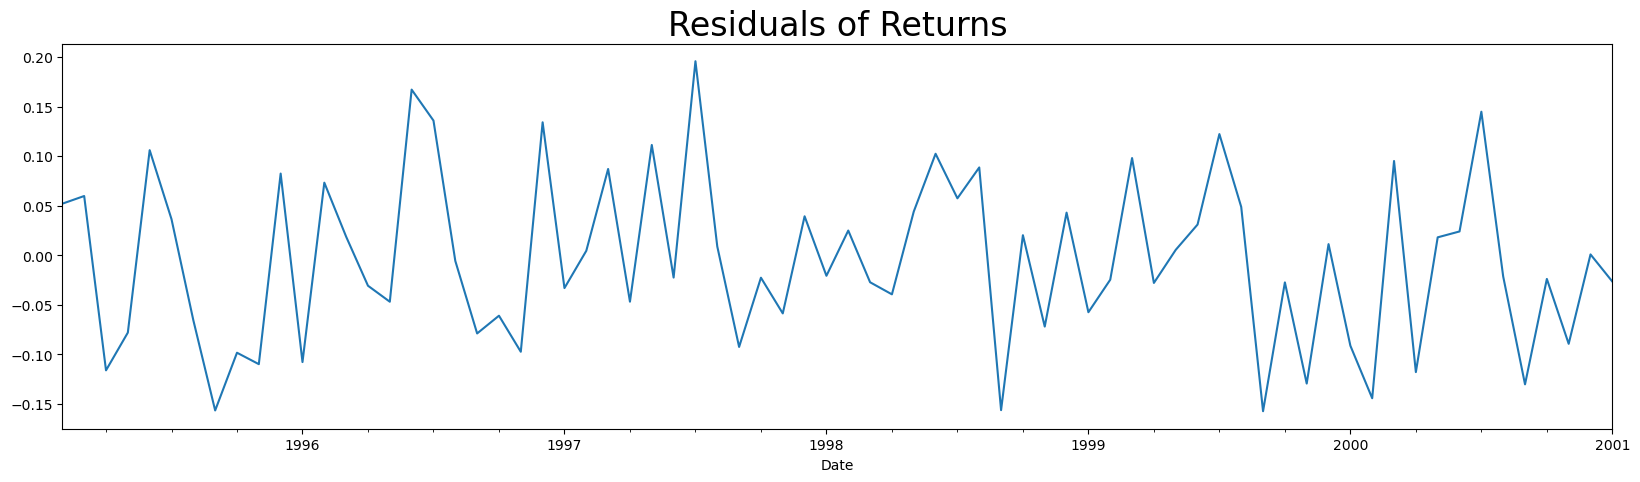

In [288]:
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

## Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [289]:
#fitting sarimax model
model = SARIMAX(train_boxcox, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit= model.fit()
y_hat_sarima = df_boxcox_diff.copy()

In [290]:
#reversing the log boxcox transformation 
y_hat_sarima['sarima_forecast_boxcox']= model_fit.predict(df_boxcox_diff.index.min(),df_boxcox_diff.index.max())
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])
y_hat_sarima['sarima_forecast']=np.exp(y_hat_sarima['sarima_forecast_boxcox'])

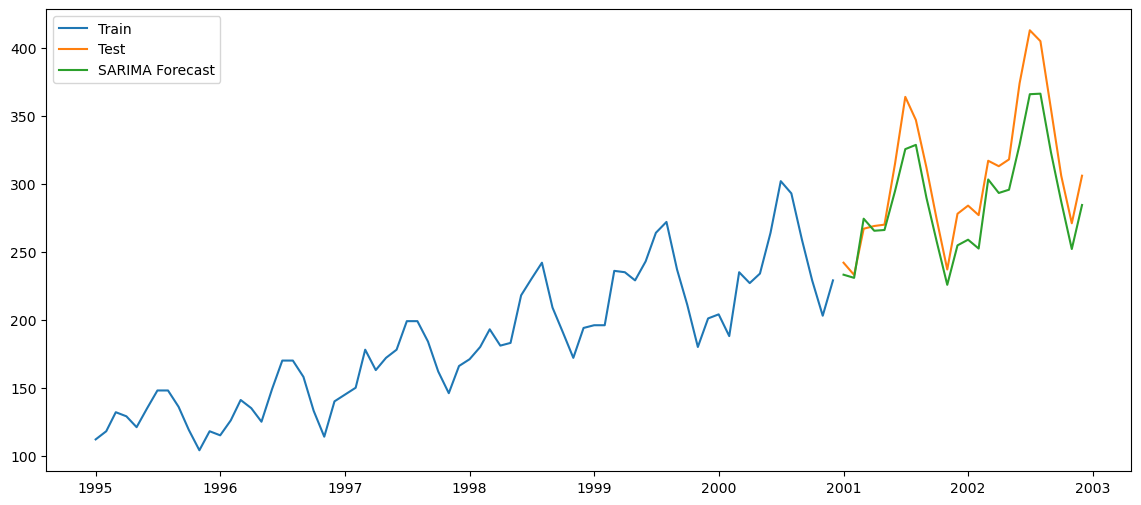

In [291]:
plt.figure(figsize=(14,6))
plt.plot(train['Passengers'], label='Train')
plt.plot(test, label='Test')
plt.plot(y_hat_sarima['sarima_forecast'][test.index.min():], label='SARIMA Forecast')
plt.legend(loc='best')
plt.show()

In our Sarima plot we have successfully captured Trend and Seasonality

In [292]:
#root mean square error
rmse_sarima = np.sqrt(mean_squared_error(test, y_hat_sarima['sarima_forecast'][test.index.min():])).round(2)
rmse_sarima

24.2

In [293]:
#mean absolute error
mape_sarima = round(np.mean(np.abs((test.Passengers - y_hat_sarima['sarima_forecast'][test.index.min():])/test.Passengers)*100),2)
mape_sarima

6.5

The performance is good comparative to other methods such as Holt's Winter additive/multiplicative, whcich also captures seasonality.

Analysing the Residuals

In [294]:
## residuals must be closer to zero or zero ##

In [295]:
model_residual = model_fit.resid
model_residual.mean()

0.03583653482734888

In [296]:
##residuals must be stationary ##

In [297]:
adf_test(model_residual)

Reject the null hypothesis
Data is stationary


In [298]:
## no autocorrelaton between the residuals ##

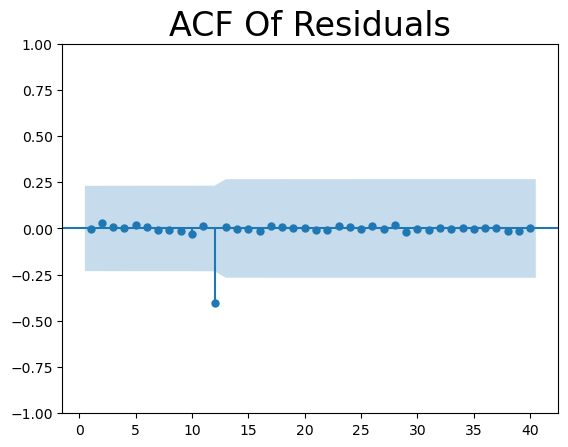

In [299]:
plot_acf(model_residual, zero = False, lags = 40)
plt.title("ACF Of Residuals",size=24)
plt.show()

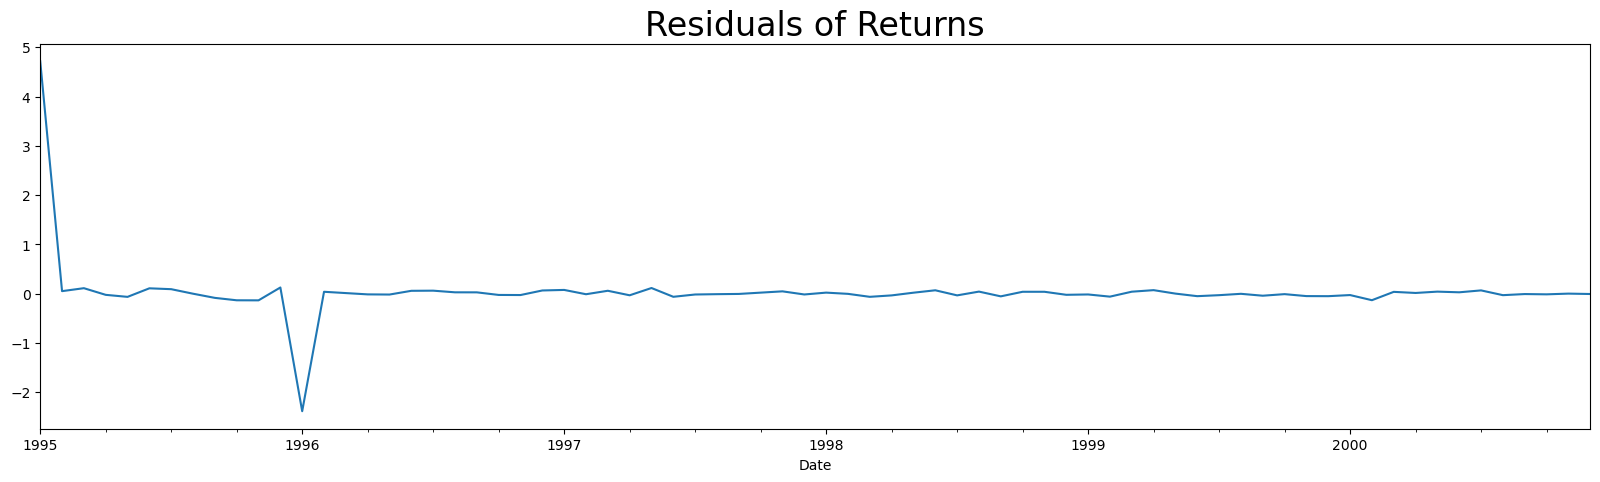

In [300]:
#residuals must be random
model_residual.plot(figsize=(20,5))
plt.title("Residuals of Returns", size=24)
plt.show()

In [301]:
#validating results
Results = {"Models":pd.Series(["Simple_Exp","holt method","holt winter","holt_mul_ad","holt_mul_mul"\
                                ,"arima","Sarima"  ]),\
        
        "Test_MAPE(%)":pd.Series([mape_ses,mape_hm,mape_hw,mape_hw_mul,mape_hw_mul_mul,mape_arima,mape_sarima]),\
        "RMSE_Values":pd.Series([test_rmse_ses,test_rmse_hm,test_rmse_hw,test_rmse_hw_mul,test_rmse_hw_mul_mul,rmse_ARIMA,
                                      rmse_sarima])}
table_evaluation=pd.DataFrame(Results)
table_evaluation.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)
table_evaluation

Models  Test_MAPE(%)  RMSE_Values
0  holt_mul_mul      6.034484    23.056799
1        Sarima      6.500000    24.200000
2   holt_mul_ad      9.368355    34.989365
3   holt winter     12.084509    47.569283
4   holt method     17.148982    71.634643
5    Simple_Exp     23.382283    91.113254
6         arima     50.300000   152.690000

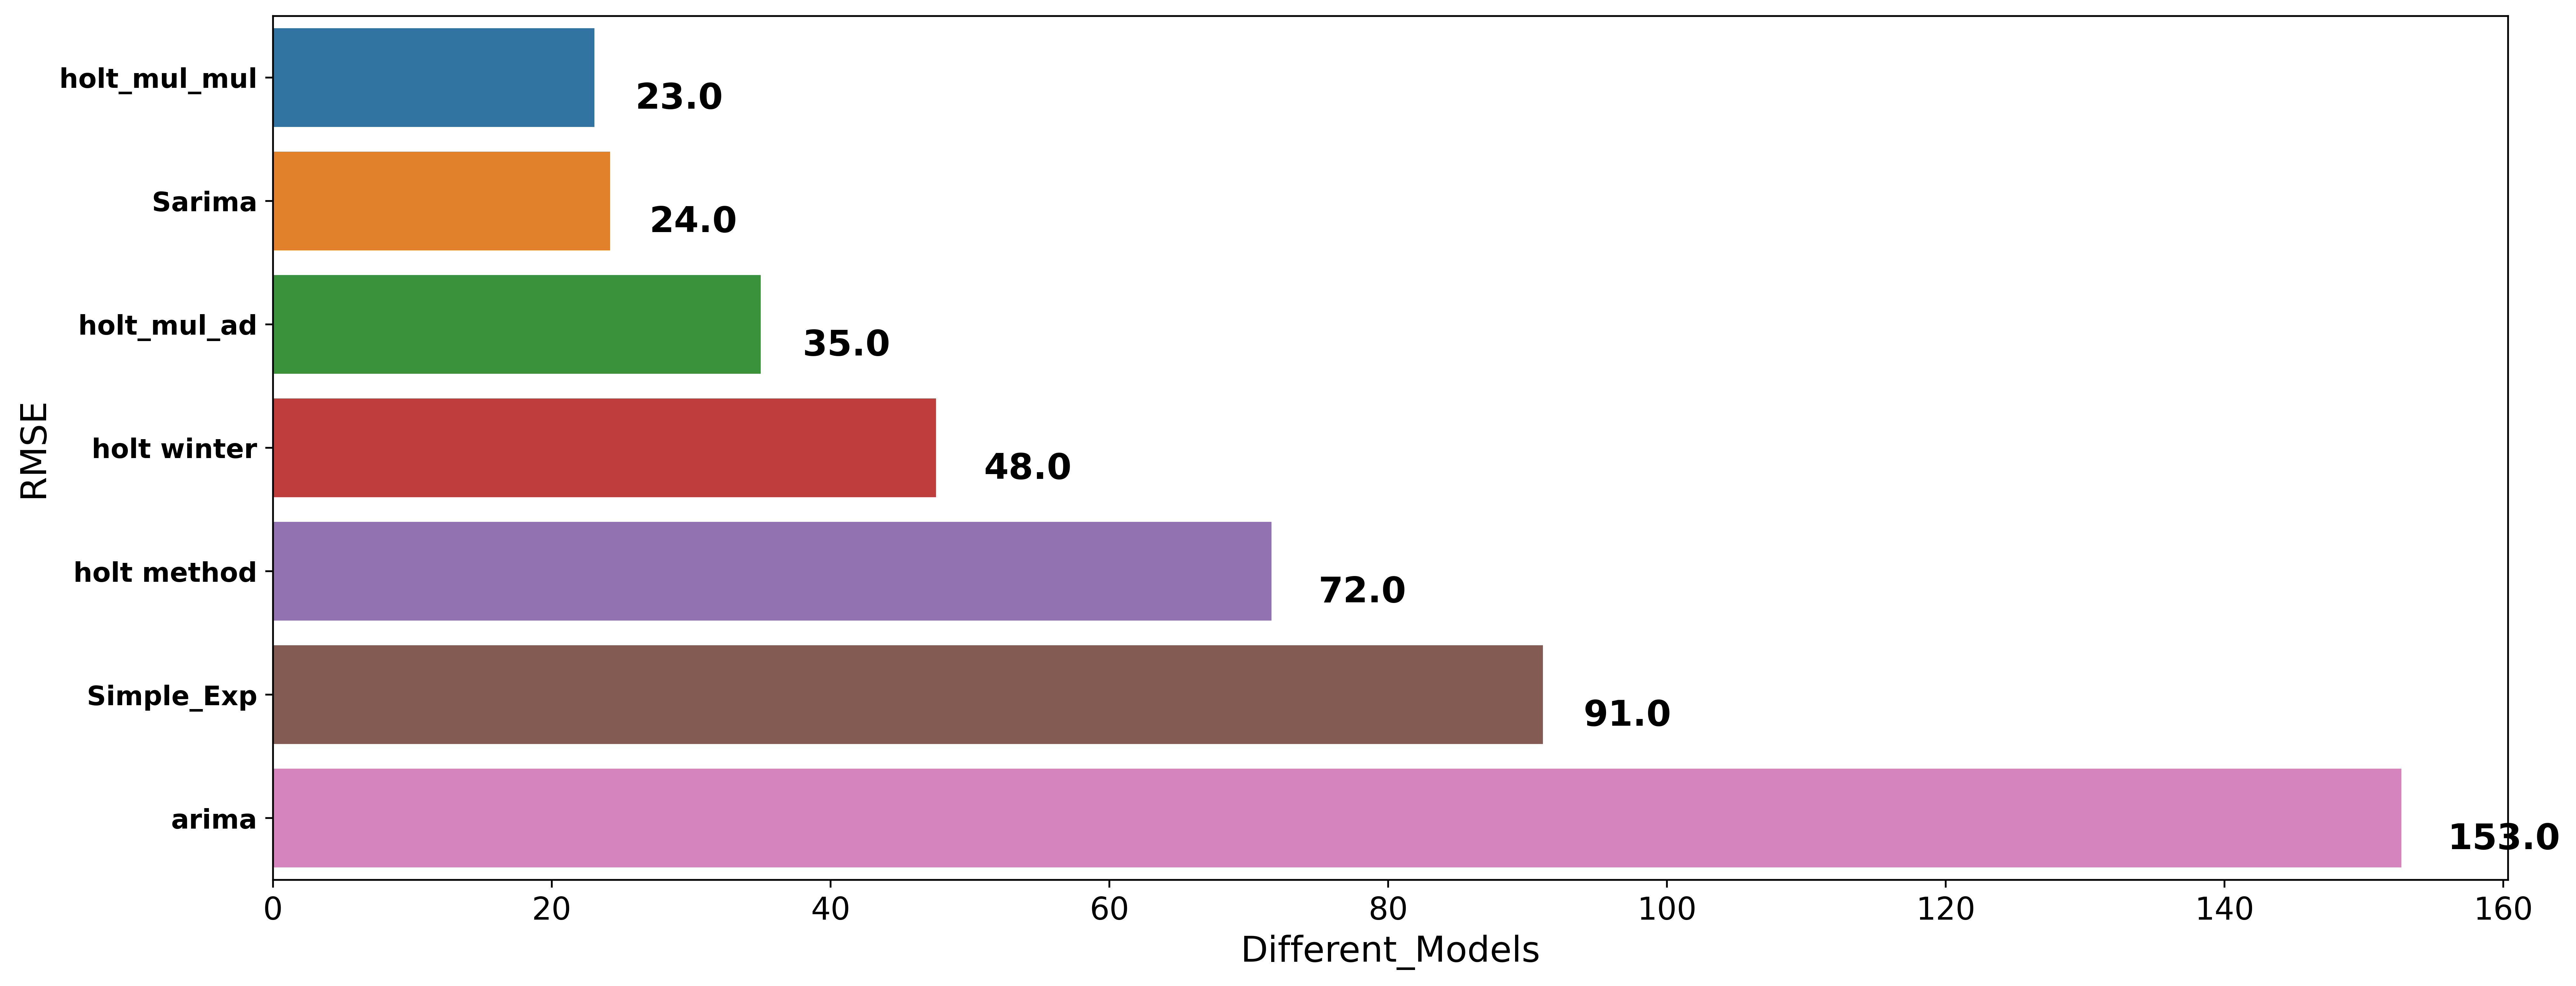

In [302]:
#plotting for all the model prepared 
f, axe = plt.subplots(1,1, figsize=(18,7), dpi=500)
sn.barplot(x='RMSE_Values', y='Models', data=table_evaluation, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=14)

for i, v in enumerate(np.round(table_evaluation.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 16)

We fixed Multiple models to analyse trends and seasonality and with some models we captured both and seperately respectively, after all observation we find that sarima model performed better ,we could better results by hyperparameter tuning for sarima, but out of all this the holts multiplicative trend and seasonality gave the best results than other models 

## Model driven Methods 

Data Preprocessing

In [303]:
df2 = df1.copy()
df2.reset_index(inplace=True)
df2['t'] = np.arange(1,len(df2)+1)
df2['t_squared'] = np.square(df2.t)
df2['month']= df2.Date.dt.strftime("%b")
df2['year'] = df2.Date.dt.strftime("%Y")
months = pd.get_dummies(df2['month'])
months = months[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]
df2 = pd.concat([df2,months],axis =1)
df2['log_passengers']= np.log(df2['Passengers'])

In [304]:
df2.head()

Date  Passengers  t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0 1995-01-01         112  1          1   Jan  1995    1    0    0    0    0   
1 1995-02-01         118  2          4   Feb  1995    0    1    0    0    0   
2 1995-03-01         132  3          9   Mar  1995    0    0    1    0    0   
3 1995-04-01         129  4         16   Apr  1995    0    0    0    1    0   
4 1995-05-01         121  5         25   May  1995    0    0    0    0    1   

   Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0    0    0    0    0    0    0    0        4.718499  
1    0    0    0    0    0    0    0        4.770685  
2    0    0    0    0    0    0    0        4.882802  
3    0    0    0    0    0    0    0        4.859812  
4    0    0    0    0    0    0    0        4.795791

In [305]:
#splitting data into train and test 
train_df = df2.iloc[:size]
test_df = df2.iloc[size:]

In [306]:
train_df

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
0  1995-01-01         112   1          1   Jan  1995    1    0    0    0    0   
1  1995-02-01         118   2          4   Feb  1995    0    1    0    0    0   
2  1995-03-01         132   3          9   Mar  1995    0    0    1    0    0   
3  1995-04-01         129   4         16   Apr  1995    0    0    0    1    0   
4  1995-05-01         121   5         25   May  1995    0    0    0    0    1   
..        ...         ...  ..        ...   ...   ...  ...  ...  ...  ...  ...   
67 2000-08-01         293  68       4624   Aug  2000    0    0    0    0    0   
68 2000-09-01         259  69       4761   Sep  2000    0    0    0    0    0   
69 2000-10-01         229  70       4900   Oct  2000    0    0    0    0    0   
70 2000-11-01         203  71       5041   Nov  2000    0    0    0    0    0   
71 2000-12-01         229  72       5184   Dec  2000    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
0     0    0    0    0    0    0    0        4.718499  
1     0    0    0    0    0    0    0        4.770685  
2     0    0    0    0    0    0    0        4.882802  
3     0    0    0    0    0    0    0        4.859812  
4     0    0    0    0    0    0    0        4.795791  
..  ...  ...  ...  ...  ...  ...  ...             ...  
67    0    0    1    0    0    0    0        5.680173  
68    0    0    0    1    0    0    0        5.556828  
69    0    0    0    0    1    0    0        5.433722  
70    0    0    0    0    0    1    0        5.313206  
71    0    0    0    0    0    0    1        5.433722  

[72 rows x 19 columns]

In [307]:
test_df

Date  Passengers   t  t_squared month  year  Jan  Feb  Mar  Apr  May  \
72 2001-01-01         242  73       5329   Jan  2001    1    0    0    0    0   
73 2001-02-01         233  74       5476   Feb  2001    0    1    0    0    0   
74 2001-03-01         267  75       5625   Mar  2001    0    0    1    0    0   
75 2001-04-01         269  76       5776   Apr  2001    0    0    0    1    0   
76 2001-05-01         270  77       5929   May  2001    0    0    0    0    1   
77 2001-06-01         315  78       6084   Jun  2001    0    0    0    0    0   
78 2001-07-01         364  79       6241   Jul  2001    0    0    0    0    0   
79 2001-08-01         347  80       6400   Aug  2001    0    0    0    0    0   
80 2001-09-01         312  81       6561   Sep  2001    0    0    0    0    0   
81 2001-10-01         274  82       6724   Oct  2001    0    0    0    0    0   
82 2001-11-01         237  83       6889   Nov  2001    0    0    0    0    0   
83 2001-12-01         278  84       7056   Dec  2001    0    0    0    0    0   
84 2002-01-01         284  85       7225   Jan  2002    1    0    0    0    0   
85 2002-02-01         277  86       7396   Feb  2002    0    1    0    0    0   
86 2002-03-01         317  87       7569   Mar  2002    0    0    1    0    0   
87 2002-04-01         313  88       7744   Apr  2002    0    0    0    1    0   
88 2002-05-01         318  89       7921   May  2002    0    0    0    0    1   
89 2002-06-01         374  90       8100   Jun  2002    0    0    0    0    0   
90 2002-07-01         413  91       8281   Jul  2002    0    0    0    0    0   
91 2002-08-01         405  92       8464   Aug  2002    0    0    0    0    0   
92 2002-09-01         355  93       8649   Sep  2002    0    0    0    0    0   
93 2002-10-01         306  94       8836   Oct  2002    0    0    0    0    0   
94 2002-11-01         271  95       9025   Nov  2002    0    0    0    0    0   
95 2002-12-01         306  96       9216   Dec  2002    0    0    0    0    0   

    Jun  Jul  Aug  Sep  Oct  Nov  Dec  log_passengers  
72    0    0    0    0    0    0    0        5.488938  
73    0    0    0    0    0    0    0        5.451038  
74    0    0    0    0    0    0    0        5.587249  
75    0    0    0    0    0    0    0        5.594711  
76    0    0    0    0    0    0    0        5.598422  
77    1    0    0    0    0    0    0        5.752573  
78    0    1    0    0    0    0    0        5.897154  
79    0    0    1    0    0    0    0        5.849325  
80    0    0    0    1    0    0    0        5.743003  
81    0    0    0    0    1    0    0        5.613128  
82    0    0    0    0    0    1    0        5.468060  
83    0    0    0    0    0    0    1        5.627621  
84    0    0    0    0    0    0    0        5.648974  
85    0    0    0    0    0    0    0        5.624018  
86    0    0    0    0    0    0    0        5.758902  
87    0    0    0    0    0    0    0        5.746203  
88    0    0    0    0    0    0    0        5.762051  
89    1    0    0    0    0    0    0        5.924256  
90    0    1    0    0    0    0    0        6.023448  
91    0    0    1    0    0    0    0        6.003887  
92    0    0    0    1    0    0    0        5.872118  
93    0    0    0    0    1    0    0        5.723585  
94    0    0    0    0    0    1    0        5.602119  
95    0    0    0    0    0    0    1        5.723585

Linear Model By Ordinary Least Square

In [308]:
linear_model = smf.ols('Passengers~t',data=train_df).fit()
pred_linear = pd.Series(linear_model.predict(pd.DataFrame(test_df['t'])))
rmse_linear = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.6677929956463

In [309]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     217.9
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           3.50e-23
Time:                        16:17:39   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             662.1
Df Residuals:                      70   BIC:                             666.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.5243      5.643     19.586      0.000      99.270     121.779
t              1.9830      0.134     14.760      0.000       1.715       2.251
==============================================================================
Omnibus:                        0.634   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.728   Jarque-Bera (JB):                0.667
Skew:                           0.213   Prob(JB):                        0.717
Kurtosis:                       2.799   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Exponential

In [310]:
exp_model = smf.ols('log_passengers~t',data=train_df).fit()
pred_exp = pd.Series(exp_model.predict(pd.DataFrame(test_df['t'])))
rmse_exp = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(np.exp(pred_exp)))**2))
rmse_exp

42.55232894600458

In [311]:
exp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     246.3
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           1.28e-24
Time:                        16:17:39   Log-Likelihood:                 48.708
No. Observations:                  72   AIC:                            -93.42
Df Residuals:                      70   BIC:                            -88.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7699      0.030    160.519      0.000       4.711       4.829
t              0.0111      0.001     15.693      0.000       0.010       0.013
==============================================================================
Omnibus:                        2.000   Durbin-Watson:                   0.687
Prob(Omnibus):                  0.368   Jarque-Bera (JB):                1.573
Skew:                          -0.186   Prob(JB):                        0.456
Kurtosis:                       2.378   Cond. No.                         84.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Quadratic

In [312]:
quad_model = smf.ols('Passengers~t+t_squared',data=train_df).fit()
pred_quad = pd.Series(quad_model.predict(pd.DataFrame(test_df[["t","t_squared"]])))
rmse_quad = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(pred_quad))**2))
rmse_quad

51.990736401554834

In [313]:
quad_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     107.4
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           6.52e-22
Time:                        16:17:40   Log-Likelihood:                -329.04
No. Observations:                  72   AIC:                             664.1
Df Residuals:                      69   BIC:                             670.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    110.2764      8.677     12.710      0.000      92.967     127.586
t              2.0031      0.549      3.652      0.001       0.909       3.097
t_squared     -0.0003      0.007     -0.038      0.970      -0.015       0.014
==============================================================================
Omnibus:                        0.649   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.723   Jarque-Bera (JB):                0.679
Skew:                           0.216   Prob(JB):                        0.712
Kurtosis:                       2.799   Cond. No.                     7.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Additive Seasonality

In [314]:
add_model = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_df).fit()
pred_add = pd.Series(add_model.predict(test_df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec']]))
rmse_add = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(pred_add))**2))
rmse_add

127.26451565320338

In [315]:
add_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     1.379
Date:                Mon, 27 Feb 2023   Prob (F-statistic):              0.206
Time:                        16:17:40   Log-Likelihood:                -371.83
No. Observations:                  72   AIC:                             767.7
Df Residuals:                      60   BIC:                             795.0
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    168.8333      5.044     33.475      0.000     158.745     178.922
Jan          -11.6667     18.126     -0.644      0.522     -47.925      24.591
Feb           -9.1667     18.126     -0.506      0.615     -45.425      27.091
Mar           17.0000     18.126      0.938      0.352     -19.258      53.258
Apr            9.5000     18.126      0.524      0.602     -26.758      45.758
May            8.5000     18.126      0.469      0.641     -27.758      44.758
Jun           29.0000     18.126      1.600      0.115      -7.258      65.258
Jul           50.0000     18.126      2.758      0.008      13.742      86.258
Aug           51.8333     18.126      2.860      0.006      15.575      88.091
Sep           28.3333     18.126      1.563      0.123      -7.925      64.591
Oct            5.3333     18.126      0.294      0.770     -30.925      41.591
Nov          -15.6667     18.126     -0.864      0.391     -51.925      20.591
Dec            5.8333     18.126      0.322      0.749     -30.425      42.091
==============================================================================
Omnibus:                       29.671   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                4.962
Skew:                           0.033   Prob(JB):                       0.0837
Kurtosis:                       1.716   Cond. No.                     1.61e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Additive Seasonality Quadratic

In [316]:
add_model_seq = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train_df).fit()
pred_add_seq = pd.Series(add_model_seq.predict(test_df[['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec','t','t_squared']]))
rmse_add_seq = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(pred_add_seq))**2))
rmse_add_seq

35.24160848593321

In [317]:
add_model_seq.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Passengers   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     101.2
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           7.45e-35
Time:                        16:17:40   Log-Likelihood:                -266.00
No. Observations:                  72   AIC:                             560.0
Df Residuals:                      58   BIC:                             591.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    101.8335      3.657     27.847      0.000      94.513     109.154
t              1.9472      0.250      7.802      0.000       1.448       2.447
t_squared      0.0009      0.003      0.259      0.797      -0.006       0.007
Jan           -6.2122      4.246     -1.463      0.149     -14.712       2.287
Feb           -5.7134      4.246     -1.346      0.184     -14.212       2.785
Mar           18.4504      4.246      4.345      0.000       9.951      26.949
Apr            8.9458      4.247      2.106      0.039       0.445      17.447
May            5.9395      4.248      1.398      0.167      -2.564      14.444
Jun           24.4315      4.250      5.748      0.000      15.923      32.940
Jul           43.4218      4.253     10.210      0.000      34.909      51.935
Aug           43.2437      4.256     10.161      0.000      34.724      51.763
Sep           17.7306      4.260      4.162      0.000       9.204      26.257
Oct           -7.2843      4.264     -1.708      0.093     -15.819       1.251
Nov          -30.3009      4.269     -7.098      0.000     -38.846     -21.756
Dec          -10.8192      4.274     -2.531      0.014     -19.375      -2.263
==============================================================================
Omnibus:                        1.717   Durbin-Watson:                   0.668
Prob(Omnibus):                  0.424   Jarque-Bera (JB):                1.039
Skew:                          -0.185   Prob(JB):                        0.595
Kurtosis:                       3.458   Cond. No.                     4.50e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.98e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Multiplicative Seasonality

In [318]:
mul_sea = smf.ols('log_passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_df).fit()
pred_mult_sea = pd.Series(mul_sea.predict(test_df))
rmse_mult_sea = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(np.exp(pred_mult_sea)))**2))
rmse_mult_sea

132.18762800263437

In [319]:
mul_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.189
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     1.268
Date:                Mon, 27 Feb 2023   Prob (F-statistic):              0.265
Time:                        16:17:40   Log-Likelihood:                 1.9383
No. Observations:                  72   AIC:                             20.12
Df Residuals:                      60   BIC:                             47.44
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7771      0.028    170.187      0.000       4.721       4.833
Jan            0.2526      0.101      2.504      0.015       0.051       0.454
Feb            0.2771      0.101      2.747      0.008       0.075       0.479
Mar            0.4229      0.101      4.192      0.000       0.221       0.625
Apr            0.3799      0.101      3.766      0.000       0.178       0.582
May            0.3680      0.101      3.648      0.001       0.166       0.570
Jun            0.4804      0.101      4.762      0.000       0.279       0.682
Jul            0.5814      0.101      5.763      0.000       0.380       0.783
Aug            0.5898      0.101      5.847      0.000       0.388       0.792
Sep            0.4825      0.101      4.783      0.000       0.281       0.684
Oct            0.3554      0.101      3.523      0.001       0.154       0.557
Nov            0.2259      0.101      2.239      0.029       0.024       0.428
Dec            0.3611      0.101      3.580      0.001       0.159       0.563
==============================================================================
Omnibus:                       56.848   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                6.403
Skew:                          -0.180   Prob(JB):                       0.0407
Kurtosis:                       1.584   Cond. No.                     1.61e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.99e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Multiplicative Additive Seasonality 

In [320]:
Mul_Add_sea = smf.ols('log_passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train_df).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(test_df))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(test_df['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea 

11.714670246780539

In [321]:
Mul_Add_sea.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_passengers   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     149.0
Date:                Mon, 27 Feb 2023   Prob (F-statistic):           1.95e-39
Time:                        16:17:40   Log-Likelihood:                 118.39
No. Observations:                  72   AIC:                            -210.8
Df Residuals:                      59   BIC:                            -181.2
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3975      0.011    383.337      0.000       4.375       4.420
t              0.0113      0.000     37.943      0.000       0.011       0.012
Jan            0.2829      0.020     14.007      0.000       0.243       0.323
Feb            0.2962      0.020     14.669      0.000       0.256       0.337
Mar            0.4306      0.020     21.334      0.000       0.390       0.471
Apr            0.3765      0.020     18.650      0.000       0.336       0.417
May            0.3532      0.020     17.497      0.000       0.313       0.394
Jun            0.4544      0.020     22.497      0.000       0.414       0.495
Jul            0.5441      0.020     26.926      0.000       0.504       0.585
Aug            0.5413      0.020     26.763      0.000       0.501       0.582
Sep            0.4227      0.020     20.879      0.000       0.382       0.463
Oct            0.2844      0.020     14.028      0.000       0.244       0.325
Nov            0.1436      0.020      7.073      0.000       0.103       0.184
Dec            0.2676      0.020     13.157      0.000       0.227       0.308
==============================================================================
Omnibus:                        4.430   Durbin-Watson:                   0.630
Prob(Omnibus):                  0.109   Jarque-Bera (JB):                3.600
Skew:                          -0.438   Prob(JB):                        0.165
Kurtosis:                       3.658   Cond. No.                     6.08e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.43e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [322]:
#preds with multiplicative additive seasonality
np.exp(pred_Mult_add_sea)

72    245.378110
73    251.466317
74    290.915247
75    278.690401
76    275.377947
77    308.136092
78    340.898573
79    343.777446
80    308.799188
81    271.947832
82    238.912819
83    273.505888
84    280.894281
85    287.863698
86    333.022490
87    319.028212
88    315.236312
89    352.735890
90    390.240432
91    393.535995
92    353.494963
93    311.309720
94    273.493201
95    313.093291
dtype: float64

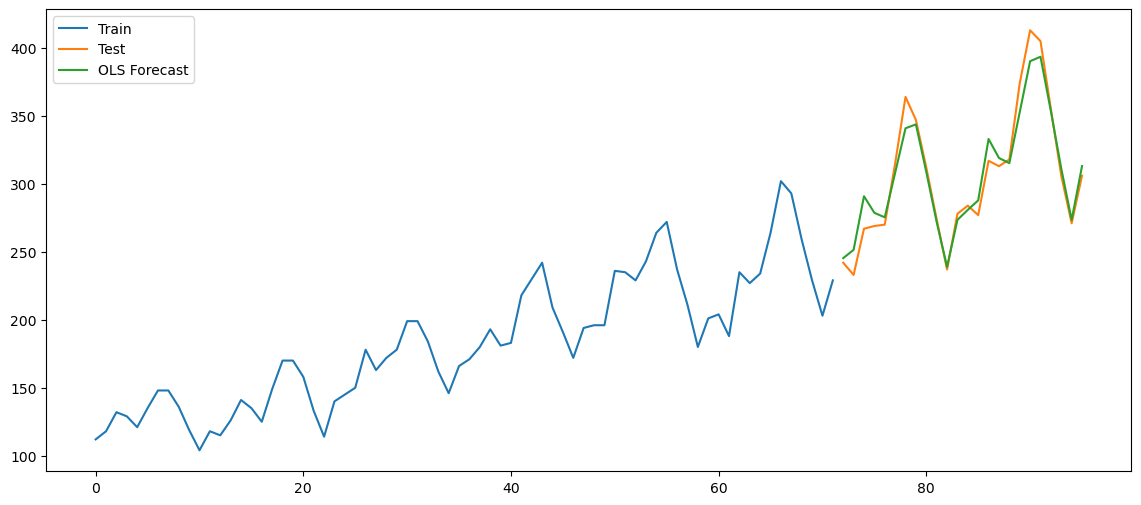

In [323]:
#plotting our preds
plt.figure(figsize=(14,6))
plt.plot(train_df['Passengers'], label='Train')
plt.plot(test_df['Passengers'], label='Test')
plt.plot(np.exp(pred_Mult_add_sea), label='OLS Forecast')
plt.legend(loc='best')
plt.show()

In [330]:
data = {"Models":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":
        pd.Series([rmse_linear,rmse_exp,rmse_quad,rmse_add,rmse_add_seq,rmse_mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

In [331]:
e = table_rmse.append(table_evaluation)
e.drop('Test_MAPE(%)', axis=1, inplace=True)
e.sort_values(['RMSE_Values'], inplace=True, ignore_index=True)

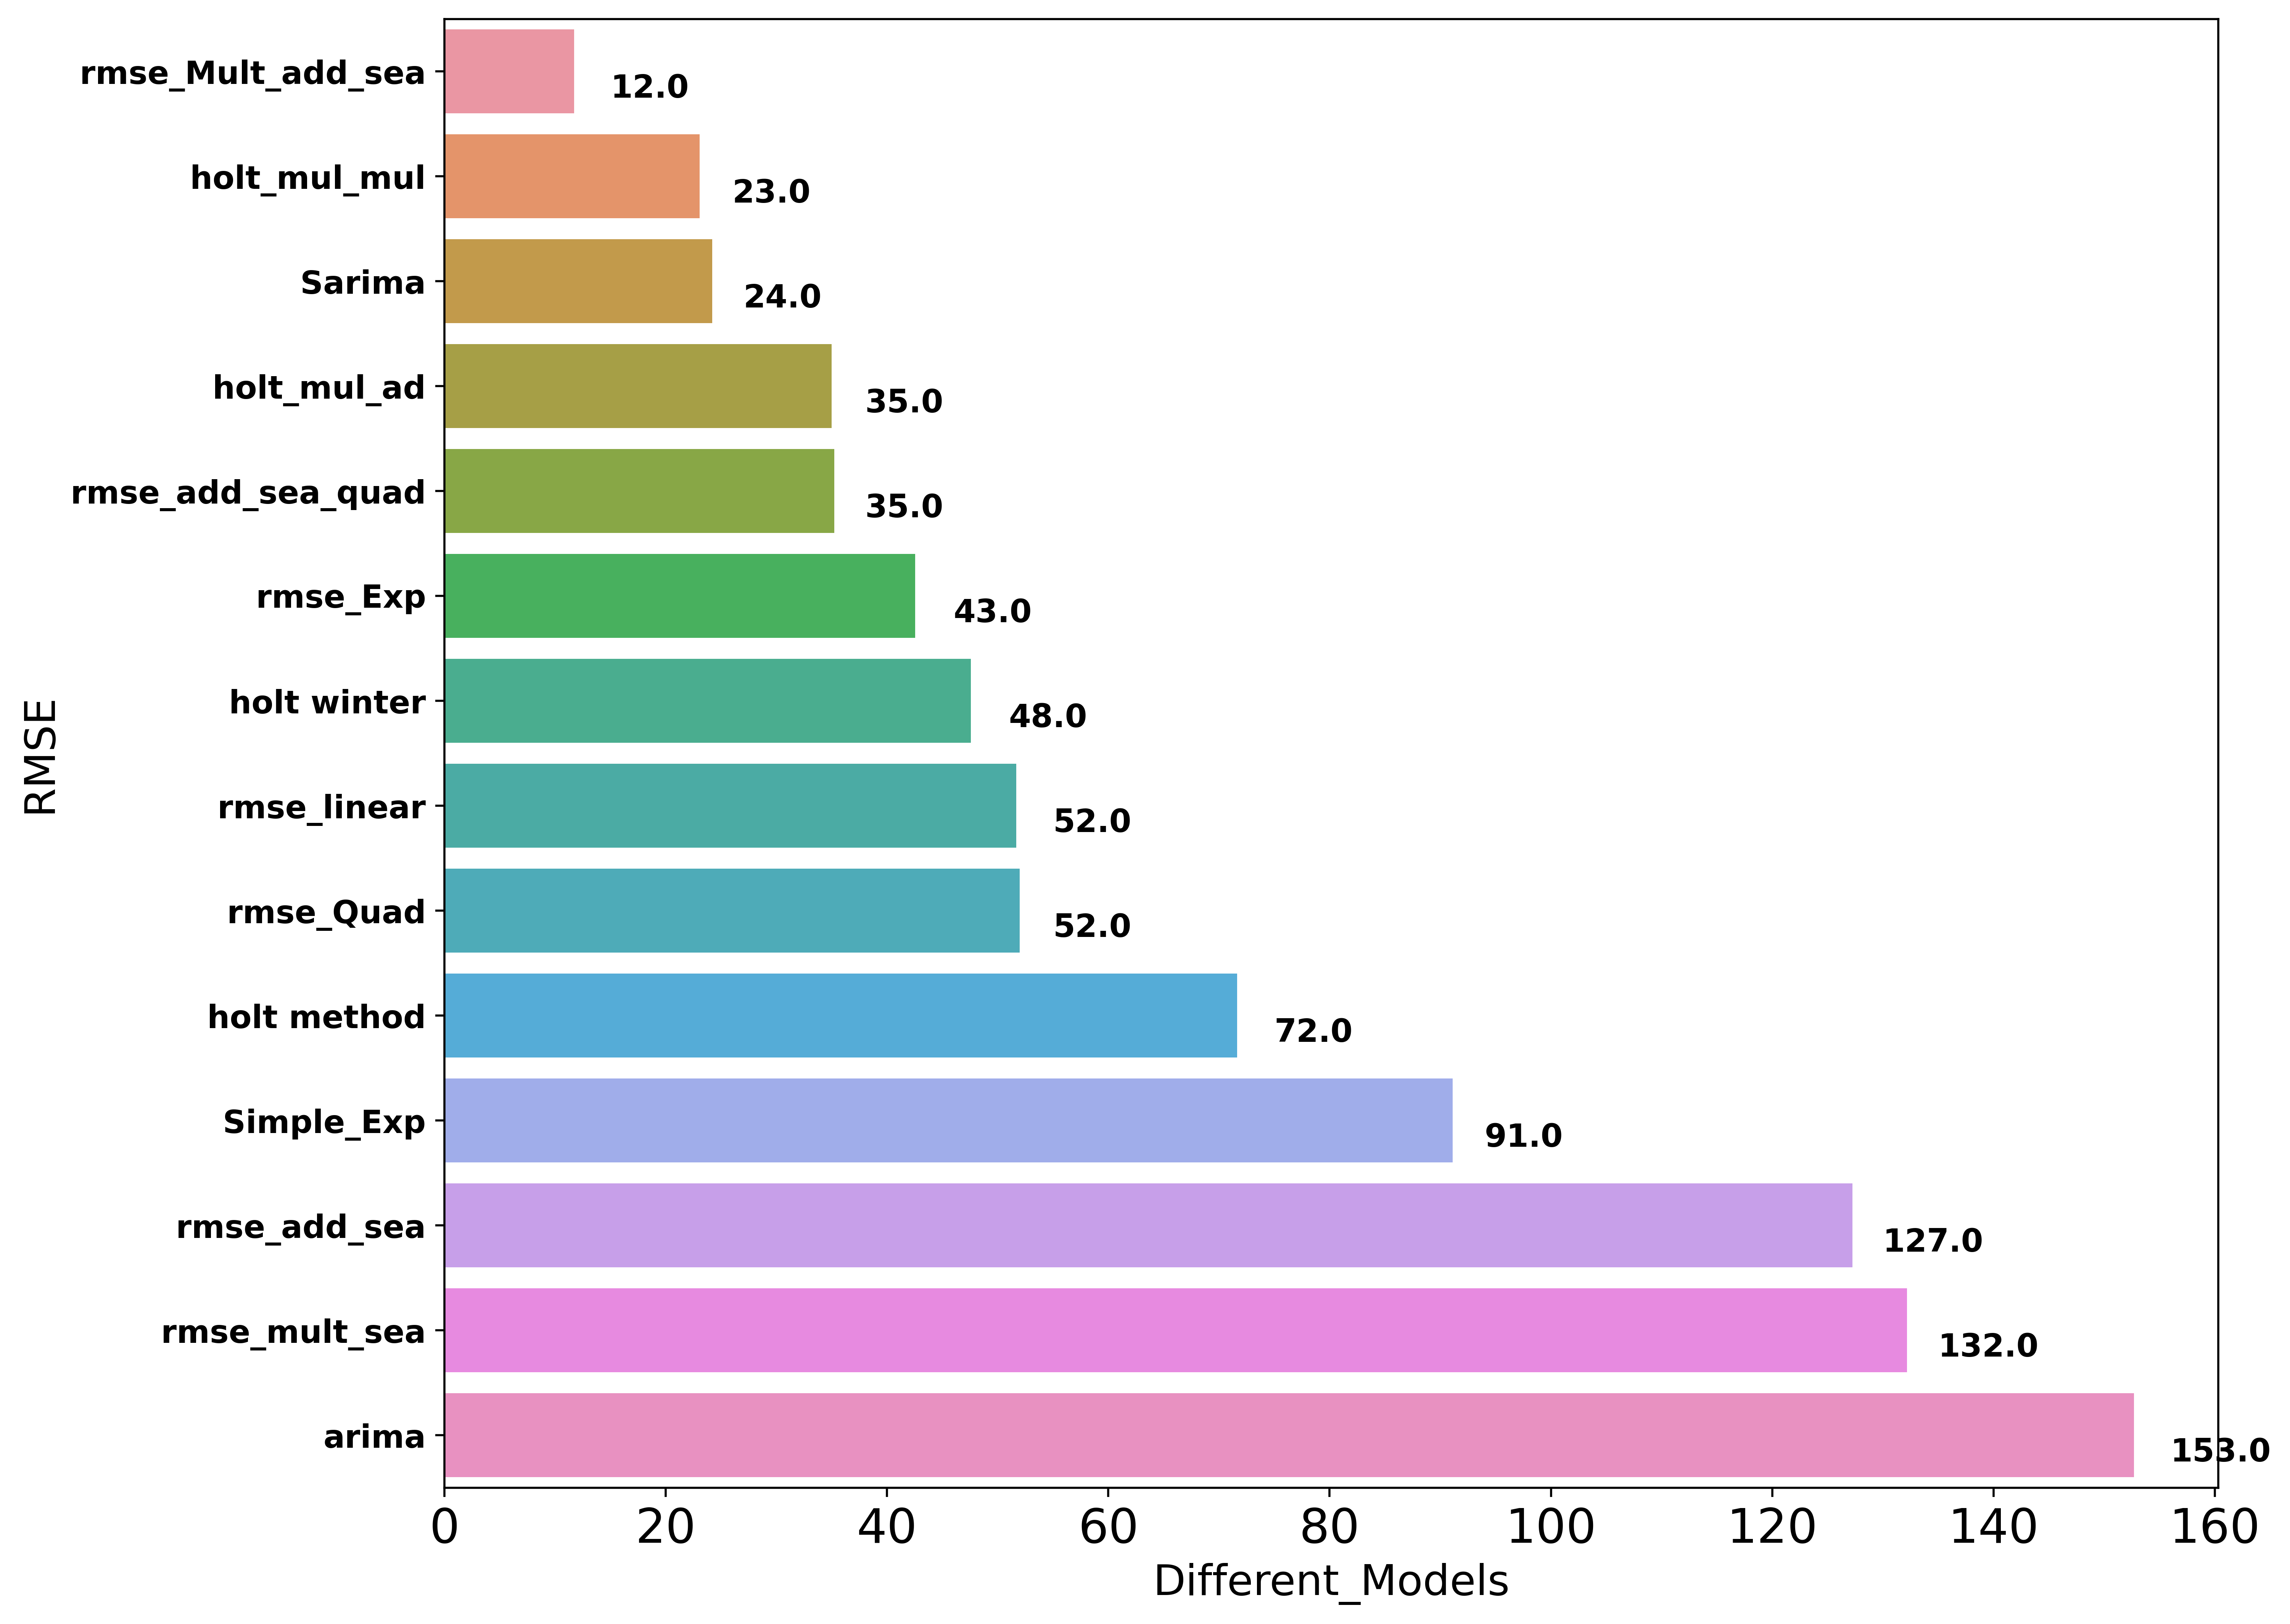

In [332]:
f, axe = plt.subplots(1,1, figsize=(12,10), dpi=500)
sn.barplot(x='RMSE_Values', y='Models', data=e, ax = axe)
axe.set_xlabel('Different_Models', size=16)
axe.set_ylabel('RMSE', size=16)
plt.yticks(fontsize=12,fontweight = 'bold')
plt.xticks(fontsize=18)

for i, v in enumerate(np.round(e.RMSE_Values.values,0)):
    axe.text(v + 3, i + .25, str(v),
            color = 'black', fontweight = 'bold', fontsize= 12)

plt.show()

Conclusion

1)We have visualized data according to week wise and day wise and have come to very great conclusions and insights about trend for forecasting in mere future, the rise we see may benefit a lot of people increasng the airlines markets shares cut

2)we applied many methods like data driven methods and model based methods including ARIMA and SARIMAX and we observed that rmse had a great impact over predictions 

3)for ARIMA Model we converted our data from non stationary  to stationary and we also detected whether our data is stationary or not by applying adfuller test.

4)with optimal parameters we performed hyperparameter tuning for ARIMA model but still we couldnt get better results compared to holts method but as holt method caaptures seasonality we cannot compare ARIMA

5)we Have also used sarimax model but as we didnt tune the hyperparameters it merely gave us good results and better than Arima.

6)we finally fit our model with multiplicative additive seasonality which gave us best results and our forecast was predicted well with minimal rmse 